<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_modulo_3/Projeto_modulo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Sejam bem-vindo e/ou bem-vinda ao meu projeto do módulo 3 do bootcamp de Data Science Alura! 

Neste módulo, aprendemos a analisar séries temporais e fazer modelos de previsão. Utilizamos dados de [COVID-19](https://www.seade.gov.br/coronavirus/) para analisar as dinâmicas de novos casos e óbitos, na cidade de São Paulo; interpretando os padrões de crescimento e periodicidade nessa série temporal. Também realizamos análises de auto-correlação e correlação cruzadas entre esses dados. Por fim, utilizamos a biblioteca [Facebook prophet](https://facebook.github.io/prophet/) para modelar previsões simples sobre o comportamento dessas séries temporais.

Como objetivo do projeto desse módulo, utilizei uma base de dados de COVID19 de escala nacional, contextualizei algumas cidades do estado de São Paulo para analisar e também examinei dados de vacinação dessas cidades. Vem comigo!

# Tema - Mobilidade pendular na Região Metropolitana de São Paulo: dinâmicas da pandemia e vacinação

A cidade de São Paulo, maior metrópole do Brasil, é o centro da também maior [Região Metropolitana](https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_S%C3%A3o_Paulo) do Brasil,formada por 39 municípios em intenso processo de conurbação.
![](https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Projeto_modulo_3/figs/SaoPaulo_RM_SaoPaulo.svg)

[Mapa](https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_S%C3%A3o_Paulo#/media/Ficheiro:SaoPaulo_RM_SaoPaulo.svg) *da Região Metropolitana de São Paulo no Estado*

A população da Região Metropolitana de São Paulo (RMSP) é estimada em cerca de [21 milhões de habitantes](https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_S%C3%A3o_Paulo). Parte desses habitantes realiza a chamada ["Migração Pendular"](https://mundoeducacao.uol.com.br/geografia/migracao-pendular.htm), o deslocamento diário de uma cidade para outra, geralmente para trabalho e/ou estudo. A RSMP concentra além da cidade de São Paulo, as cidades do chamado [Grande ABC](https://pt.wikipedia.org/wiki/Regi%C3%A3o_do_Grande_ABC), com seus polos industriais, e o munícipo de Guarulhos, onde está localizado o [maior aeroporto da América do Sul](https://pt.wikipedia.org/wiki/Aeroporto_Internacional_de_S%C3%A3o_Paulo-Guarulhos). 

Os dados do [censo de 2000](https://www.scielo.br/j/spp/a/tJPPNLfJmTZLWyh7S5KH8BJ/?lang=pt#) indicam que cerca de 1 milhão de habitantes da RMSP realizam deslocamento pendular entre municípios da RMSP, sendo o município de São Paulo o maior [destino](http://produtos.seade.gov.br/produtos/spp/v19n04/v19n04_06.pdf), recebendo cerca de 590 mil pessoas diariamente. Além de maior polo de serviços, as conexões de transporte público entre os municípios limítrofes da RMSP facilitam essa migração diária.

## COVID19 e São Paulo

A evolução da pandemia de COVID19 foi bastante severa na cidade de São Paulo, sendo uma das cidades mais afetadas e com um dois maiores índices de mortes em [2021](https://g1.globo.com/sp/sao-paulo/noticia/2021/05/27/cidade-de-sao-paulo-ja-tem-mais-mortos-por-covid-19-que-nova-york-e-cidade-do-mexico.ghtml). Sendo a maior e mais ativa cidade do país, é de se esperar que fosse uma das regiões de maior dificuldade de controle da pandemia. De fato, mesmo com [antecipações de feriados](https://www.redebrasilatual.com.br/saude-e-ciencia/2021/03/isolamento-social-fase-roxa-emergencial-sao-paulo/), as taxas de isolamento de São Paulo se mantiveram [baixas](https://g1.globo.com/sp/sao-paulo/noticia/2021/04/03/isolamento-social-nao-mudou-e-ficou-abaixo-dos-45percent-nos-feriados-antecipados-na-cidade-de-sp.ghtml). 
Dessa forma, podemos imaginar que o intenso fluxo de pessoas indo e vindo de São Paulo todos os dias, sobretudo trabalhadores essenciais e da saúde, promoveu aumento das infecções por COVID19 nos municípios de intensa migração pendular na RMSP.

Por outro lado, podemos imaginar também que, devidas às proporções do muncípio de São Paulo e seus [gastos com a pandemia](https://www.terra.com.br/noticias/coronavirus/pandemia-tem-custo-de-r-6-bilhoes-para-a-prefeitura-de-sao-paulo,ad0f8a5eac7695384bb95ff45ace6fd2x7hwbz24.html), a sua rede de saúde também é uma das maiores e mais bem equipadas do Brasil. Podemos esperar que, por exemplo, o ritmo de vacinação nos demais municípios da RMSP também seja influenciado pelas dinâmicas do município de São Paulo.

### Hipóteses

Dessa forma, podemos chegar em algumas hipóteses sobre o efeito da migração pendular na dinâmica da pandemia na RMSP:

1.   O intenso fluxo diário de pessoas entre São Paulo e outros municípios da RMSP influenciaram a dinâmica da pandemia nos municipíos de maior migração pendular, aumentando os números de casos e mortes;
2.   Os aportes do sistema de saúde de São Paulo e capilaridade do SUS influencia a dinâmica de vacinação; de forma a observarmos ritmos e taxas de vacinação semelhantes.

Portanto, nesse projeto eu examinei alguns municípios da RMSP, comparando as dinâmicas de casos, mortes e vacinação com o município de São Paulo. Por último, modelei previsões sobre o total de vacinas aplicadas em São Paulo e nos municípios escolhidos.



## Municípios escolhidos

![](https://github.com/RPGraciotti/BootCampAlura/raw/main/Projeto_modulo_3/figs/1024px-Mapa-RMSP-subregions.svg.png)

[Mapa](https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_S%C3%A3o_Paulo) *das sub-regiões da RMSP*

**Vermelho: sub-região Norte, Verde: sub-região Leste, Azul-claro: sub-região Sudeste, Azul-escuro: sub-região Sudoeste, Amarelo: sub-região Oeste**

Como estamos falando de 39 municípios, separados em [5 sub-regiões](https://governo-sp.jusbrasil.com.br/legislacao/1028148/lei-complementar-1139-11), selecionei apenas alguns municípios para análise. Me baseei em [um levantamento](http://produtos.seade.gov.br/produtos/spp/v19n04/v19n04_06.pdf) da [SEADE](https://www.seade.gov.br/), que identificou os municípios da RMSP com maior fluxo para São Paulo.

![](https://github.com/RPGraciotti/BootCampAlura/raw/main/Projeto_modulo_3/figs/munic.png)

*Modificado de: Aranha, São Paulo em Perspectiva v. 19, n.4, pg. 96-109, 2005*

Como podemos ver nos dois mapas acima, podemos destacar os municípios de **Osasco**, **Guarulhos**, **São Bernardo do Campo**, **Francisco Morato** e **Taboão da Serra** entre os municípios com migração de > 20.000 pessoas diariamente ao município de São Paulo. Selecionei estes municípios para as análises por também serem um de cada sub-região.

Importante ressaltar que, no levantamento utilizado como base, há um índice decrescente de migração entre os primeiros colocados: 
Osasco (80.762 indivíduos que realizam migração pendular) > Guarulhos (78.949) > São Bernardo do Campo (37.706). No estudo não há identificação do número de indivíduos que se deslocam de Francisco Morato e Taboão da Serra pra São Paulo.

# Importando bibliotecas e dados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime
import statsmodels.tsa.stattools as smt

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Uma breve descrição sobre os conjuntos de dados:

Para os novos casos e mortes de COVID19, utilizei a base do [Brasil.io](https://brasil.io/dataset/covid19/caso_full/), que compila os dados de boletins diários das secretarias de saúde em escala nacional, utilizando especificamente o conjunto "casos_full". Como alguns dos municípios escolhidos apresentaram algumas vezes valores negativos de novos casos e mortes, provavelmente devido a correções de registro de dias anteriores, eu optei por trocar esses valores para 0.

Para os dados de vacinação do estado de São Paulo, que utilizei para nortear as análises de vacinação dos municípios, utilizei a base de dados do Governo do Estado, o [Vacinometro](https://vacinaja.sp.gov.br/vacinometro/) do estado. 

Já para os dados de vacinação de cada município, eu utilizei o sistema do [Ministério da Saúde](https://qsprod.saude.gov.br/extensions/DEMAS_C19Vacina/DEMAS_C19Vacina.html), que permite a pesquisa dos dados de vacinação diária por município individualmente.

Os conjuntos de dados foram manipulados para conter somente os dados até o dia 30 de Junho, pois a cada dia o total é atualizado em todas as bases, e o acesso em datas diferentes pode resultar em totais diferentes.

In [2]:
casos_full = pd.read_csv("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/caso_full.csv.gz?raw=true", 
                         compression = "gzip")

casos_full.loc[:,"date"] = pd.to_datetime(casos_full.loc[:,"date"], format = "%Y-%m-%d")

casos_full = casos_full[casos_full.date != "2021-07-01"]

casos_full.loc[casos_full.loc[:,'new_confirmed'] < 0, 'new_confirmed'] = 0
casos_full.loc[casos_full.loc[:,'new_deaths'] < 0, 'new_deaths'] = 0

In [3]:
vac_estado = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/20210630_evolucao_aplicacao_doses.csv",
                              sep = ";")

vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de janeiro de ", "/01/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de fevereiro de ", "/02/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de março de ", "/03/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de abril de ", "/04/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de maio de ", "/05/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de junho de ", "/06/")

vac_estado.iloc[:,0] = pd.to_datetime(vac_estado.iloc[:,0], format = "%d/%m/%Y")

vac_estado = vac_estado.rename(columns = {"Dia de Data Registro Vacina": "date"})

In [4]:
vac_sp = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/sao_paulo.xlsx?raw=true")
vac_sp = vac_sp[:-1]

vac_osa = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/osasco.xlsx?raw=true")
vac_osa = vac_osa[:-1]

vac_gru = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/guarulhos.xlsx?raw=true")
vac_gru = vac_gru[:-1]

vac_sbc = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/sbc.xlsx?raw=true")
vac_sbc = vac_sbc[:-1]

vac_fm = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/francisco_morato.xlsx?raw=true")
vac_fm = vac_fm[:-1]

vac_tab = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/taboao.xlsx?raw=true")
vac_tab = vac_tab[:-1]

In [5]:
df_sp = casos_full.query("city == 'São Paulo'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_sp.loc[:,"ma_cases"] = df_sp.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_sp.loc[:,"ma_deaths"] = df_sp.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_osa = casos_full.query("city == 'Osasco'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_osa.loc[:,"ma_cases"] = df_osa.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_osa.loc[:,"ma_deaths"] = df_osa.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_gru = casos_full.query("city == 'Guarulhos'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_gru.loc[:,"ma_cases"] = df_gru.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_gru.loc[:,"ma_deaths"] = df_gru.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_sbc = casos_full.query("city == 'São Bernardo do Campo'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_sbc.loc[:,"ma_cases"] = df_sbc.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_sbc.loc[:,"ma_deaths"] = df_sbc.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_fm = casos_full.query("city == 'Francisco Morato'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_fm.loc[:,"ma_cases"] = df_fm.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_fm.loc[:,"ma_deaths"] = df_fm.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_tab = casos_full.query("city == 'Taboão da Serra'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_tab.loc[:,"ma_cases"] = df_tab.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_tab.loc[:,"ma_deaths"] = df_tab.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

In [6]:
df_cities = pd.concat([df_sp, df_osa, df_gru, df_sbc, df_fm, df_tab],
                  axis = 0, join = 'inner', keys = ["São Paulo","Osasco","Guarulhos",
                                                    "São Bernando do Campo", "Francisco Morato",
                                                    "Taboão da Serra"]).reset_index()

df_cities.drop("level_1", axis = 1, inplace = True)

df_cities.rename(columns = {'level_0':'cidade'}, inplace=True)

# Análises


Após a importação das diferentes bases dados, e da filtragem dos municípios da base "casos_full", prosseguimos para as análises.

## Casos diários

Vamos primeiro olhar para a dinâmica de novos casos de covid em São Paulo e nos nossos municípios escolhidos. A expectativa é de que as trajetórias sejam parecidas entre os municípios e São Paulo, guardadas as devidas proporções:

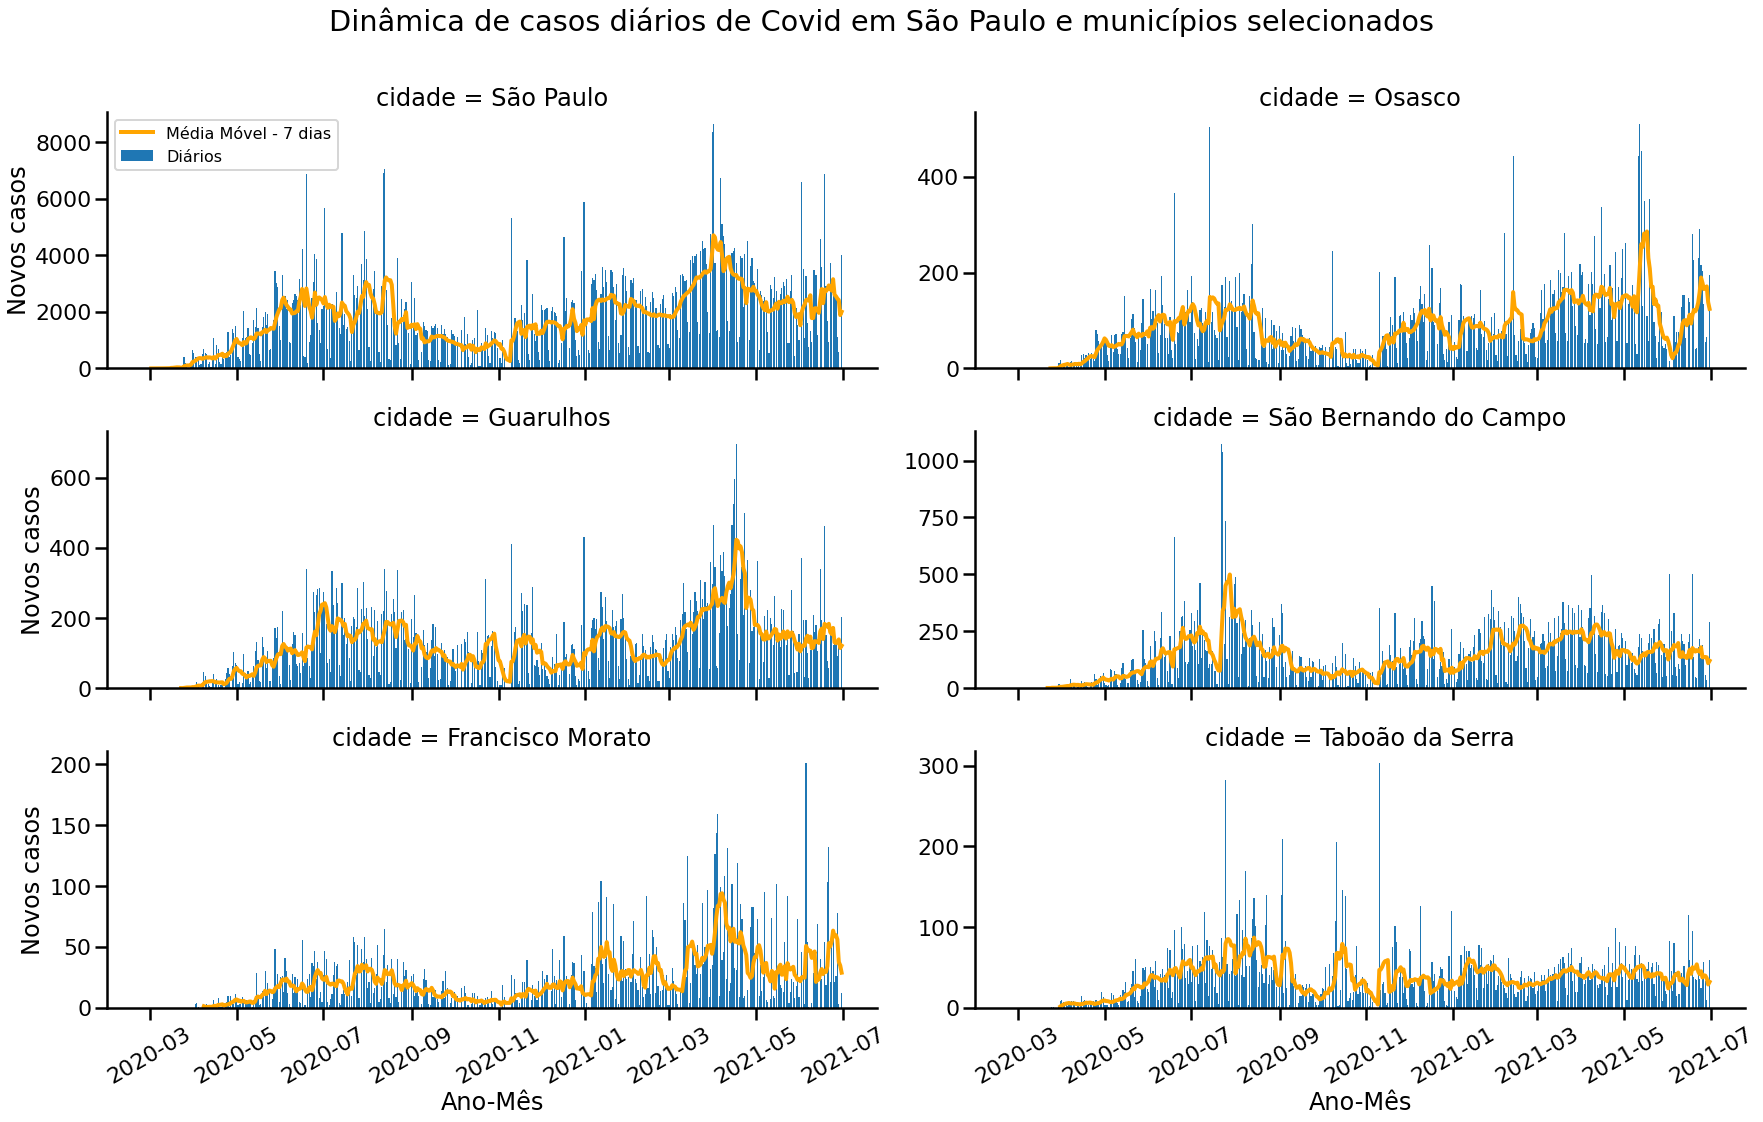

In [7]:
sns.set_context("poster")
g = sns.FacetGrid(data = df_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.5)
g.map_dataframe(plt.bar, x = "date", height = "new_confirmed", label = "Diários")
g.map_dataframe(sns.lineplot, x = "date", y = "ma_cases", linewidth = 4, label = "Média Móvel - 7 dias", color = "orange")
g.set_xticklabels(rotation = 30)
g.set_axis_labels("Ano-Mês", "Novos casos")
g.axes[0].legend(fontsize = 16, loc = "upper left")
g.fig.suptitle("Dinâmica de casos diários de Covid em São Paulo e municípios selecionados", y = 1.05)
plt.tight_layout()
plt.show()

A dinâmica de São Paulo é marcada pelo aumento de casos nos primeiros meses da pandemia, seguido de estabilidade nos meses de Julho-Agosto de 2020, seguido de queda até o final de 2020. Porém, há uma retomada elevada de novos casos no início de 2021, atingindo picos mais altos durante o mês de Abril. Vemos por último, uma relativa queda e estabilidade em Maio e Junho de 2021.

Podemos ver, portanto, que a dinâmica é de fato muito parecida entre São Paulo e as cidades de maior migração. São Bernado do Campo parece ter respondido melhor a pandemia em 2021 que outras cidades, assim como Taboão da Serra, que apresentaram os maiores picos durante 2020. Francisco Morato é a [menor cidade analisada](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o), e de maior distância da capital, mas apresentou dinâmica bastante parecida com São Paulo.

Há uma outra forma de se analisar a correspondência das séries temporais:

Na matemática, a análise de [correlação cruzada](https://en.wikipedia.org/wiki/Cross-correlation), pode ser utilizada para examinar a correspondência entre duas séries temporais. Da página da wiki (tradução livre): 

`Suponha duas séries temporais idênticas, ao calcular-se a integral do produto das duas funções a cada posição, deslocando-se uma série em relação à outra, o produto é máximo quando as duas séries se alinham perfeitamente.`

Portanto, podemos estimar o quanto é necessário "atrasar" uma série temporal que para que ela apresente maior correlação com a outra, em séries temporais não idênticas. Dessa forma, séries temporais de dinâmicas parecidas devem apresentar maior correspondência com menores atrasos, e conforme se distanciam, menor correspondência. Vamos aplicar esse tipo de análise aos nossos dados:

Primeiro, realizei a análise de auto-correlação do município de São Paulo com ele mesmo, depois a correlação cruzada de São Paulo com os outros municípios.

### Casos

In [8]:
sp_sp = smt.ccf(df_sp.loc[:,"new_confirmed"], df_sp.loc[:,"new_confirmed"], unbiased = False)
sp_sp_lag = range(0, len(df_sp))

sp_osa = smt.ccf(df_sp.loc[:,"new_confirmed"], df_osa.loc[:,"new_confirmed"], unbiased = False)
sp_osa_lag = range(0, len(df_osa))

sp_gru = smt.ccf(df_sp.loc[:,"new_confirmed"], df_gru.loc[:,"new_confirmed"], unbiased = False)
sp_gru_lag = range(0, len(df_gru))

sp_sbc = smt.ccf(df_sp.loc[:,"new_confirmed"], df_sbc.loc[:,"new_confirmed"], unbiased = False)
sp_sbc_lag = range(0, len(df_sbc))

sp_fm = smt.ccf(df_sp.loc[:,"new_confirmed"], df_fm.loc[:,"new_confirmed"], unbiased = False)
sp_fm_lag = range(0, len(df_fm))

sp_tab = smt.ccf(df_sp.loc[:,"new_confirmed"], df_tab.loc[:,"new_confirmed"], unbiased = False)
sp_tab_lag = range(0, len(df_tab))

In [9]:
corrs = [sp_sp, sp_osa, sp_gru, sp_sbc, sp_fm, sp_tab]
corr_lags = [sp_sp_lag, sp_osa_lag, sp_gru_lag, sp_sbc_lag, sp_fm_lag, sp_tab_lag]
cidades = ["São Paulo", "Osasco", "Guarulhos", "São Bernardo do Campo", "Francisco Morato", "Taboão da Serra"]

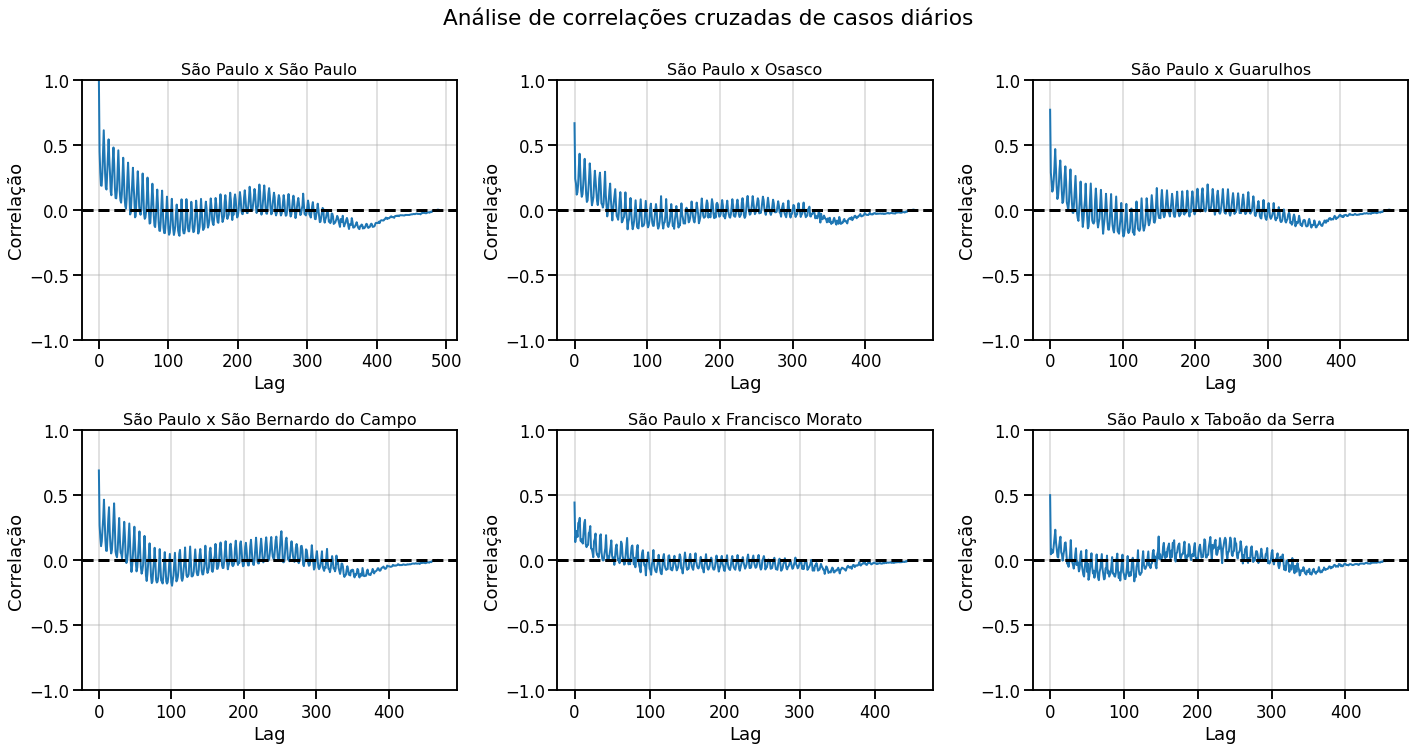

In [10]:
sns.set_context("talk")
fig = plt.figure(figsize = (20, 10))

for k in range(1,7):
  fig.add_subplot(2, 3, k)
  plt.suptitle("Análise de correlações cruzadas de casos diários", y = 1.05)
  plt.title("São Paulo x " + cidades[k -1], fontsize = 16)
  plt.plot(corr_lags[k - 1], corrs[k - 1], lw = 2)
  plt.ylim(-1,1)
  plt.xlabel("Lag")
  plt.ylabel("Correlação")
  plt.grid(alpha = .5)
  plt.axhline(y = 0, color = "black", lw = 3, ls = "--")
 
plt.tight_layout()
plt.show()

In [11]:
sns.reset_orig()

Para interpretar esse gráfico, primeiro nos atentemos aos eixos. O eixo x mostra o quanto a segunda série temporal foi deslocada em relação a primeira (no caso, em dias), e o eixo y representa o produto da integral das duas séries (rescalonada para os valores -1,1). Quando a correlação é máxima, temos o valor de 1. 

Tomando a auto correlação de São Paulo como exemplo, vemos que no início há o pico esperado de valor 1, quando as duas séries são idênticas. Ao aumentarmos o deslocamento (lag), temos uma redução desse valor, mas temos um leve aumento mais à frente no tempo. Isso está indicando para nós que a dinâmica do início se repetiu em algum momento. No nosso caso, tivemos de fato uma repetição de alta de casos seguida de uma queda no início de 2021.

Dessa forma, podemos observar então que há grande correlação entre as dinâmicas entre São Paulo e as 3 maiores cidades, Osasco Guarulhos e São Bernardo do Campo, que mantiveram valores altos nos primeiros momentos. Para Taboão da Serra, observamos uma queda mais rápida nos valores de correlação no começo da análise, quando comparado com as outras cidades.

Por outro lado, por mais que a primeira análise tenha revelado padrões similares entre São Paulo e Francisco Morato, a correlação se manteve próxima de 0 na maior parte do tempo. Olhando novamente a dinâmica de novos casos do município, na verdade vemos que Francisco Morato apresentou uma diferença de intensidade muito maior que São Paulo. Por mais que ambas cidades tenham repetido o aumento de casos em 2021, o aumento de novos casos em Francisco Morato foi maior que o aumento de São Paulo em relação ao ano anterior, e isso poderia estar por trás das menores correlações observadas.

## Mortes

Outro aspecto importante para se analisar a dinâmica de transmissão da COVID19 é o número de mortes diárias. 

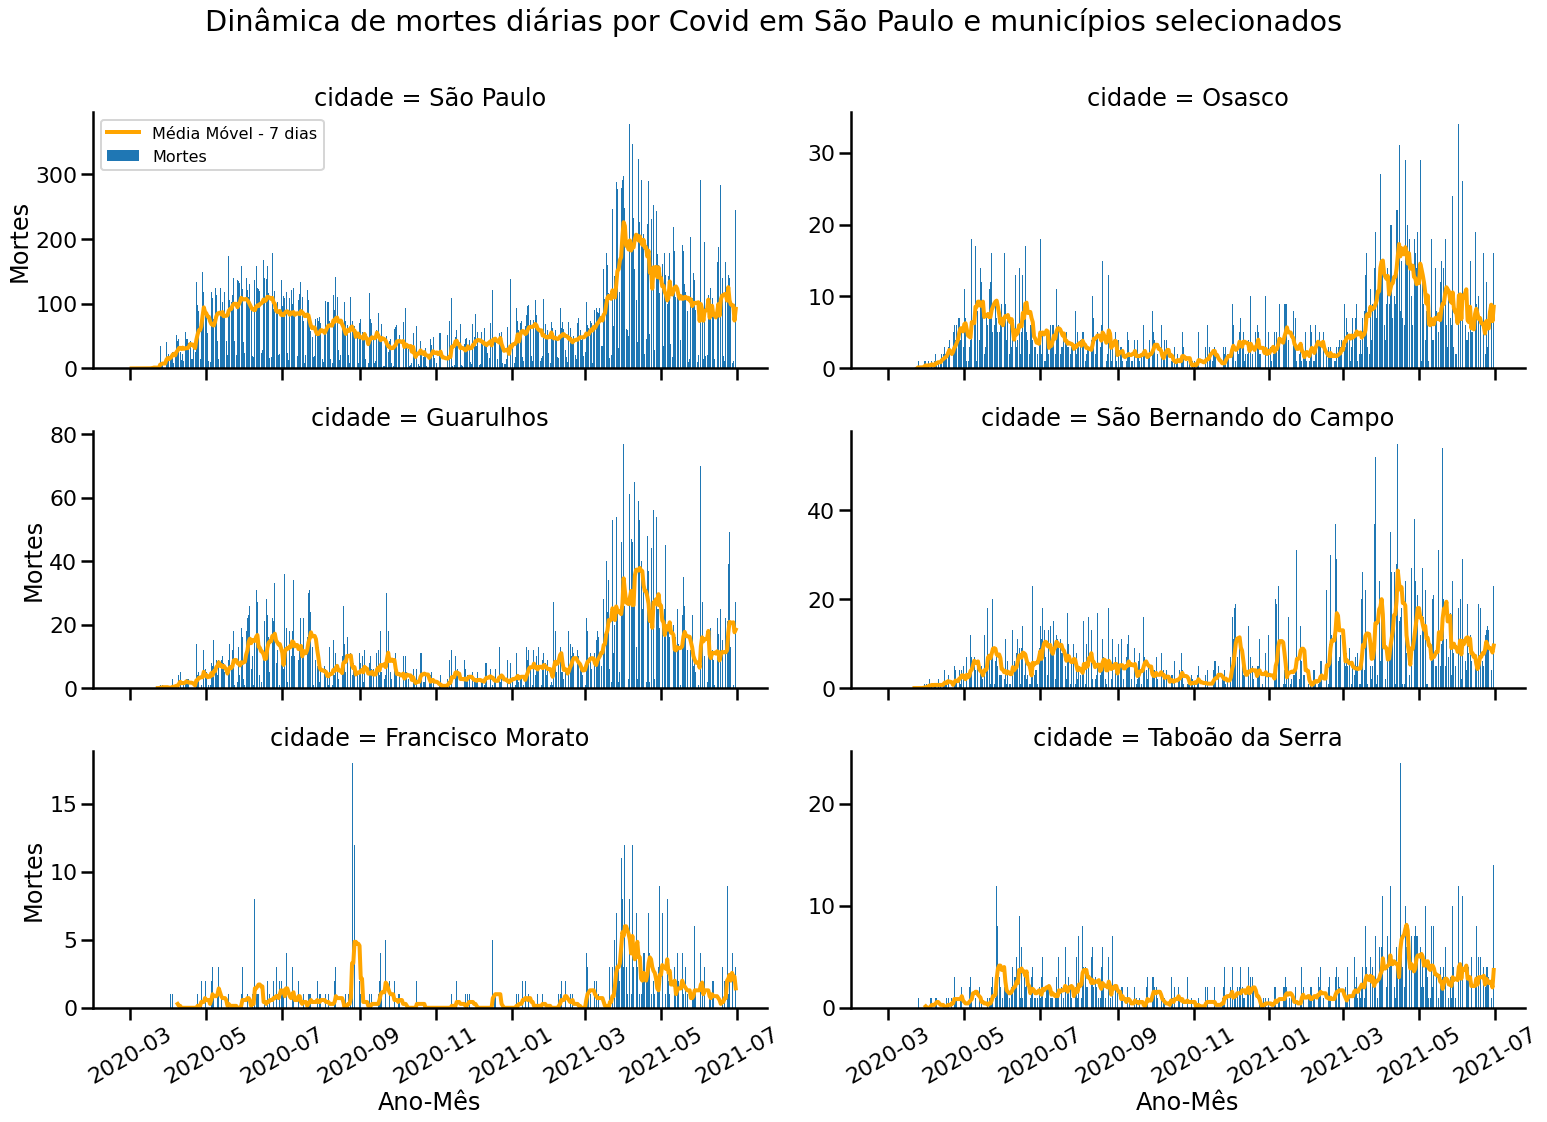

In [12]:
sns.set_context("poster")
g = sns.FacetGrid(data = df_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.2)
g.fig.suptitle("Dinâmica de mortes diárias por Covid em São Paulo e municípios selecionados", y = 1.05)
g.map_dataframe(plt.bar, x = "date", height = "new_deaths", label = "Mortes")
g.map_dataframe(sns.lineplot, x = "date", y = "ma_deaths", linewidth = 4, label = "Média Móvel - 7 dias", color = "orange")
g.set_axis_labels("Ano-Mês", "Mortes")
g.set_xticklabels(rotation = 30)
g.axes[0].legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
plt.show()

Dessa vez, temos dinâmicas mais similares entre si, pois mesmo em cidades que tiveram menos casos novos diários em 2021, houve aumento no número de mortes em relação ao ano passado. Podemos destacar uma dinâmica mais errática em 2021 para São Bernardo do Campo, evidenciado pela média móvel, mas, no geral, as dinâmicas são bastante parecidas. 

Vamos examinar então as correlações:

### Correlação

In [13]:
sp_sp = smt.ccf(df_sp.loc[:,"new_deaths"], df_sp.loc[:,"new_deaths"], unbiased = False)
sp_sp_lag = range(0, len(df_sp))

sp_osa = smt.ccf(df_sp.loc[:,"new_deaths"], df_osa.loc[:,"new_deaths"], unbiased = False)
sp_osa_lag = range(0, len(df_osa))

sp_gru = smt.ccf(df_sp.loc[:,"new_deaths"], df_gru.loc[:,"new_deaths"], unbiased = False)
sp_gru_lag = range(0, len(df_gru))

sp_sbc = smt.ccf(df_sp.loc[:,"new_deaths"], df_sbc.loc[:,"new_deaths"], unbiased = False)
sp_sbc_lag = range(0, len(df_sbc))

sp_fm = smt.ccf(df_sp.loc[:,"new_deaths"], df_fm.loc[:,"new_deaths"], unbiased = False)
sp_fm_lag = range(0, len(df_fm))

sp_tab = smt.ccf(df_sp.loc[:,"new_deaths"], df_tab.loc[:,"new_deaths"], unbiased = False)
sp_tab_lag = range(0, len(df_tab))

In [14]:
corrs = [sp_sp, sp_osa, sp_gru, sp_sbc, sp_fm, sp_tab]
corr_lags = [sp_sp_lag, sp_osa_lag, sp_gru_lag, sp_sbc_lag, sp_fm_lag, sp_tab_lag]
cidades = ["São Paulo", "Osasco", "Guarulhos", "São Bernardo do Campo", "Francisco Morato", "Taboão da Serra"]

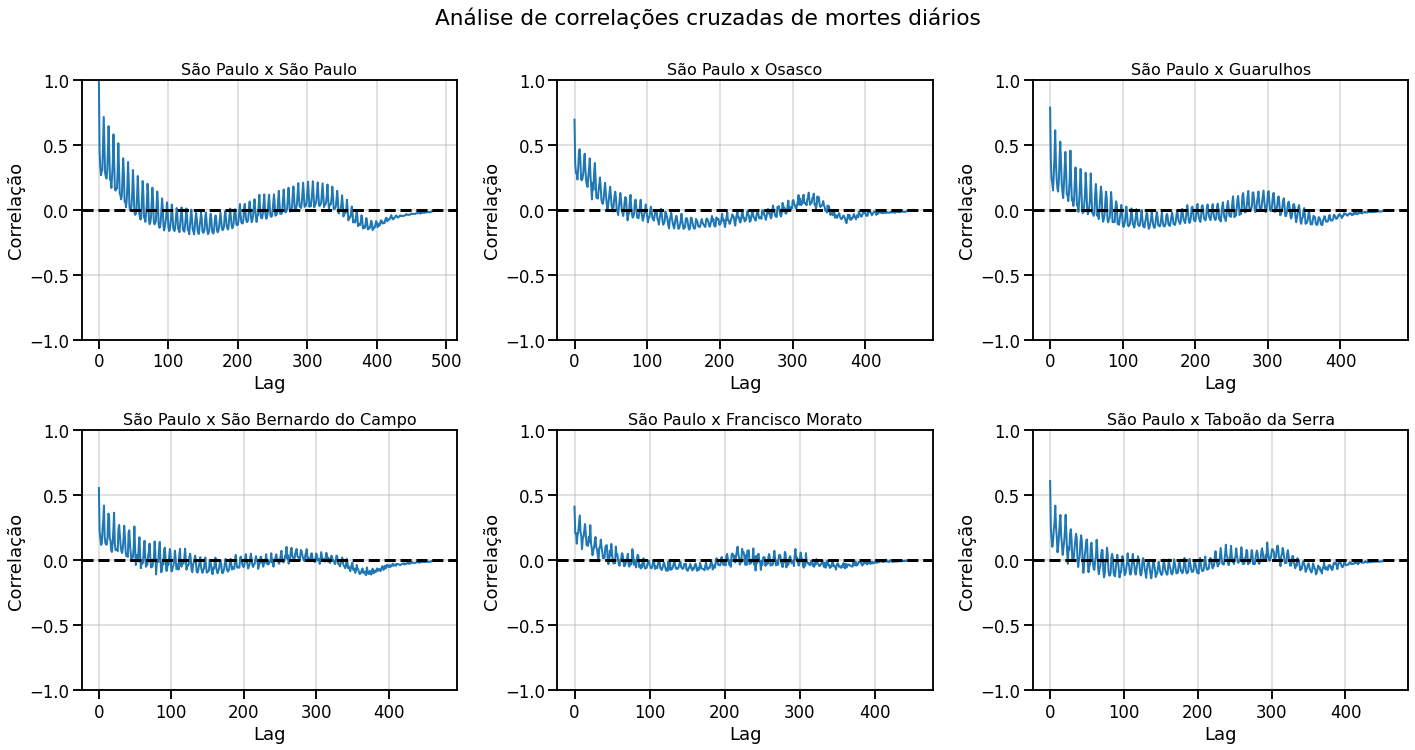

In [15]:
sns.set_context("talk")
fig = plt.figure(figsize = (20, 10))

for k in range(1,7):
  fig.add_subplot(2, 3, k)
  plt.suptitle("Análise de correlações cruzadas de mortes diários", y = 1.05)
  plt.title("São Paulo x " + cidades[k -1], fontsize = 16)
  plt.plot(corr_lags[k - 1], corrs[k - 1], lw = 2)
  plt.ylim(-1,1)
  plt.xlabel("Lag")
  plt.ylabel("Correlação")
  plt.grid(alpha = .5)
  plt.axhline(y = 0, color = "black", lw = 3, ls = "--")

plt.tight_layout()
plt.show()

Como esperado, em geral as correlações se apresentam melhores quando comparadas às correlações de casos diários, a exemplo da correlação São Paulo x Taboão da Serra, um pouco mais expressiva que a anterior. Novamente, as dinâmicas das 3 maiores cidades se mostraram mais próximas, e Francisco Morato manteve valores próximos de 0 por mais tempo. Nesse caso, podemos observar que quase não houve mortes concentradas em períodos próximos no município, à exceção de poucos dias com grandes picos mais espalhados. 

# Vacinação

Bom, agora vamos tentar examinar outra hipótese sobre a dinâmica de migração pendular e saúde. Se assumirmos que a proximidade dos municípios da RMSP facilita a integração do sistema de saúde, poderíamos esperar vários fatores sendo influencidados como número de leitos de UTI disponíveis e ocupados, transporte de pacientes da RMSP para à capital, etc. Certamente são dados interessantes de serem analisados e estão disponíveis, mas para este projeto eu decidi focar nos dados de vacinação contra COVID19. 

A vacinação no Brasil teve início no dia 17 de Janeiro de 2021, [marcada por turbulências políticas](https://noticias.uol.com.br/ultimas-noticias/afp/2021/01/17/brasil-aplica-primeira-vacina-contra-a-covid-19-em-meio-a-uma-guerra-politica.htm) e [atraso](https://www.cnnbrasil.com.br/saude/2020/12/24/quais-os-paises-que-ja-comecaram-a-vacinacao-contra-a-covid-19) em relação ao resto do mundo. O foco da campanha inicial foram os trabalhadores da saúde e idosos, em todo o território nacional. Conforme a campanha de vacinação foi avançando, maiores quantidades foram distribuídas, mais vacinas aprovadas, o ritmo de vacinação foi aumentando e novos grupos passaram a ser imunizados. Os calendários de vacinação variam bastante entre estados e municípios, seguindo as demandas de distribuições etárias e grupos prioritários. No momento da redação final deste projeto, por exemplo, Manaus já está vacinando todas as [pessoas maiores de 26 anos](https://g1.globo.com/am/amazonas/noticia/2021/07/02/manaus-vacina-pessoas-a-partir-de-26-anos-contra-a-covid-19.ghtml), enquanto que em Brasília, a faixa etária se encontra dos [46 aos 59 anos](https://www.correiobraziliense.com.br/cidades-df/2021/07/4934863-covid-19-agendamento-para-populacao-com-46-anos-inicia-nesta-quinta.html). 

Outro fator muito importante na dinâmica de vacinação, conforme veremos logo mais, é que a grande maioria das vacinas aplicadas no Brasil requer duas doses para imunização completa. [Já iniciamos a aplicação com a vacina desenvolvida pela farmacêutica Janssen](https://www.uol.com.br/vivabem/noticias/redacao/2021/06/26/vacina-da-janssen-covid-19-sao-paulo.htm), que requer apenas uma dose, mas até o momento da redação do projeto ela não corresponde a um contingente expressivo do total de vacinas aplicadas, e também [não há previsões](https://oglobo.globo.com/sociedade/saude/apos-100-milhoes-de-doses-aplicadas-veja-cronograma-de-chegada-de-vacinas-contra-covid-19-ate-fim-do-ano-25087336) de que ela se torne a vacina mais aplicada no Brasil. A necessidade de duas doses de vacinação, com tempo de espera entre uma dose e outra variando a depender do fabricante, gera maiores dificuldades de análises de comparação e previsões de vacinação como um todo. Vamos exemplificar algumas dessas questões olhando primeiro para os dados do Estado de São Paulo:


*Nota: para essas análises, já havia pelo menos 4 dias de dados sobre a aplicação da vacina da Janssen em São Paulo, mas eu os removi para facilitar a análise do resto.*

In [16]:
vac_estado_means = vac_estado.copy()
vac_estado_means.loc[(vac_estado_means["Dose"] == "1° DOSE"), "ma"] = vac_estado_means.loc[vac_estado_means.Dose.shift() == "1° DOSE", "Contagem de Dose"].rolling(window = 7, center = False).mean()
vac_estado_means.loc[(vac_estado_means["Dose"] == "2° DOSE"), "ma"] = vac_estado_means.loc[vac_estado_means.Dose.shift() == "2° DOSE", "Contagem de Dose"].rolling(window = 7, center = False).mean()

In [17]:
vac_estado_means = vac_estado_means[:-4]

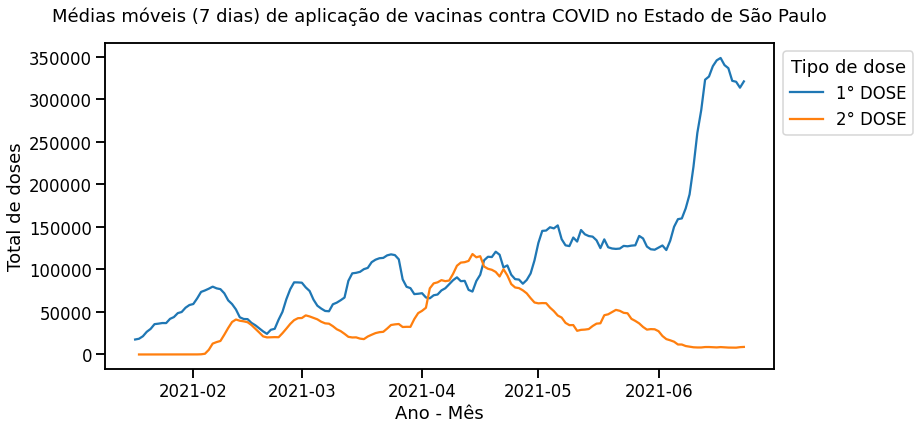

In [18]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.lineplot(data = vac_estado_means, x = "date", y = "ma", hue = "Dose")
plt.title("Médias móveis (7 dias) de aplicação de vacinas contra COVID no Estado de São Paulo", y = 1.05)
plt.ylabel("Total de doses")
plt.xlabel("Ano - Mês")
plt.legend(bbox_to_anchor = (1.22, 1), title = "Tipo de dose")
plt.show()

O que nós podemos observar nesse gráfico? Primeiro, há um "atraso" em relação às aplicações de primeira e segunda dose. As primeiras vacinas aplicadas no estado de São Paulo foram da fabricante Coronavac, que possui 21-28 dias de espera recomendada entre as [duas doses](https://butantan.gov.br/covid/butantan-tira-duvida/tira-duvida-noticias/quais-sao-as-diferencas-entre-as-vacinas-contra-covid-19-que-estao-sendo-aplicadas-no-brasil).

[Logo em seguida](https://www.prefeitura.sp.gov.br/cidade/secretarias/saude/noticias/?p=307888) iniciou-se o uso da vacina fabricada pela AstraZeneca/Oxford, que possui um tempo muito maior previsto entre as duas doses, de 9-12 semanas. Podemos ver que o número de segundas doses aplicadas subiu bastante entre Abril e Maio, provenientes das primeiras doses desse imunizante aplicadas em Janeiro. Houve então um período de queda desse total, mas ao mesmo tempo houve um aumento expressivo de aplicações de primeiras doses. Isso se deve as ampliações de grupos prioritários [(sessão "documentos técnicos")](https://www.prefeitura.sp.gov.br/cidade/secretarias/saude/vigilancia_em_saude/index.php?p=307599), e um grande aporte de novas doses, [sobretudo da fabricante Pfizer](https://g1.globo.com/sp/sao-paulo/noticia/2021/06/11/governo-de-sp-vai-distribuir-vacinas-contra-covid-19-da-pfizer-e-da-janssen-para-todos-os-municipios.ghtml) no meio de Junho.

Essas dinâmicas por si só seriam bastante interesantes de se analisar e modelar, previsões de como o aumento de aplicações de primeiras doses prevê o aumento de segundas doses, por exemplo. Porém, para facilitar a análise dos objetivos propostos nesse projeto, eu considerei focar apenas no **total** de doses aplicadas e taxas diárias, independente de ser segunda ou primeira dose
Não podemos considerar somente a dinâmica de aplições de segundas doses para analisar, pois ele não reflete a real capacidade de vacinação dos sistemas de saúde; devido aos diferentes prazos entre uma dose e outra. Por último, se a maior parte da vacinação ocorrerá com vacinas de duas doses, seria interessante analisar o total de doses tendo em mente que esse número deve corresponder **ao dobro** da população. Levando isso em conta, na prática é como se **dobrassemos** os dados populacionais para as análises.


---

Tendo tudo isso em mente, vamos examinar a dinâmica do total de doses aplicadas no estado para balizar nossas expectativas com relação aos muncípios.

*Nota: também convém dizer que os dados disponíveis no sistema do SUS para análise corresponde também ao total diário de doses, sem discriminação de primeira ou segunda dose.*

In [47]:
duas_doses = vac_estado.groupby("date").sum().reset_index()
duas_doses_means = duas_doses.copy()
duas_doses_means.loc[:,"ma"] = duas_doses_means.loc[:,"Contagem de Dose"].rolling(window = 7, center = False).mean()

In [48]:
duas_doses.loc[:,"cumulativo"] = duas_doses.loc[:,"Contagem de Dose"].cumsum()

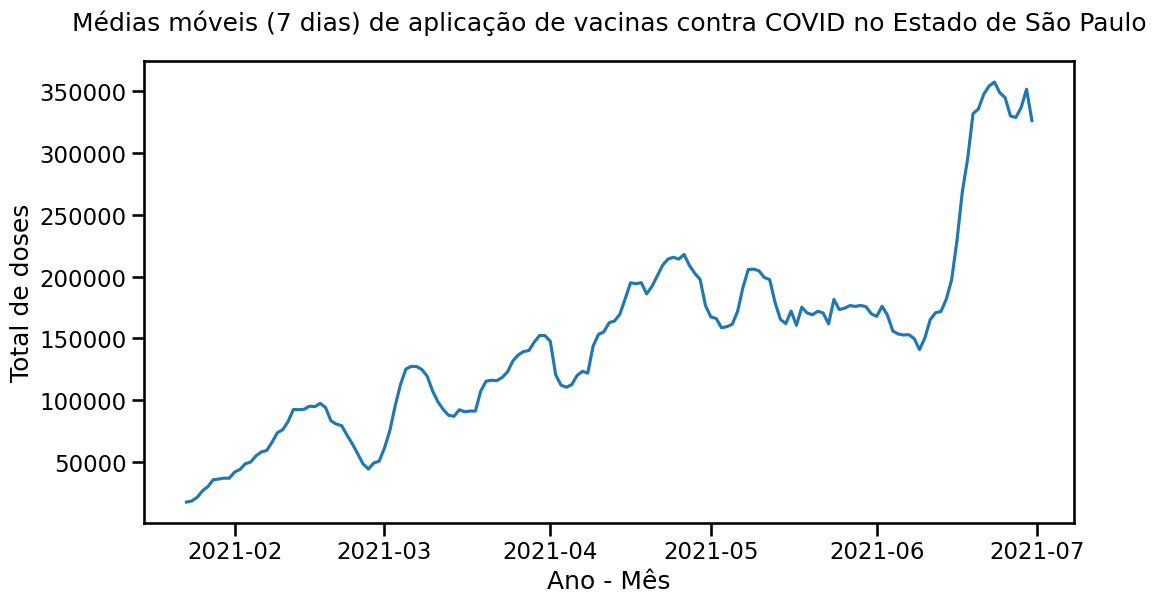

In [49]:
sns.set_context("talk")
plt.figure(figsize = (12,6))

sns.lineplot(data = duas_doses_means, x = "date", y = "ma")
plt.title("Médias móveis (7 dias) de aplicação de vacinas contra COVID no Estado de São Paulo", y = 1.05)
plt.ylabel("Total de doses")
plt.xlabel("Ano - Mês")
plt.show()

Agora fica mais claro observar que a taxa de doses diárias aplicadas está aumentando no estado. 

# Cidades

In [50]:
vac_sp.loc[:,"ma"] = vac_sp.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_sp.loc[:,"cumulativo"] = vac_sp.loc[:,"Doses Aplicadas"].cumsum()

vac_osa.loc[:,"ma"] = vac_osa.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_osa.loc[:,"cumulativo"] = vac_osa.loc[:,"Doses Aplicadas"].cumsum()

vac_gru.loc[:,"ma"] = vac_gru.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_gru.loc[:,"cumulativo"] = vac_gru.loc[:,"Doses Aplicadas"].cumsum()

vac_sbc.loc[:,"ma"] = vac_sbc.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_sbc.loc[:,"cumulativo"] = vac_sbc.loc[:,"Doses Aplicadas"].cumsum()

vac_fm.loc[:,"ma"] = vac_fm.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_fm.loc[:,"cumulativo"] = vac_fm.loc[:,"Doses Aplicadas"].cumsum()

vac_tab.loc[:,"ma"] = vac_tab.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_tab.loc[:,"cumulativo"] = vac_tab.loc[:,"Doses Aplicadas"].cumsum()

In [51]:
vac_cities = pd.concat([vac_sp, vac_osa, vac_gru, vac_sbc, vac_fm, vac_tab],
                       axis = 0, join = "inner", keys = ["São Paulo","Osasco","Guarulhos",
                                                    "São Bernando do Campo", "Francisco Morato",
                                                    "Taboão da Serra"]).reset_index()

vac_cities.drop("level_1", axis = 1, inplace = True)
vac_cities.rename(columns = {"level_0": "cidade"}, inplace = True)

## Taxas diárias

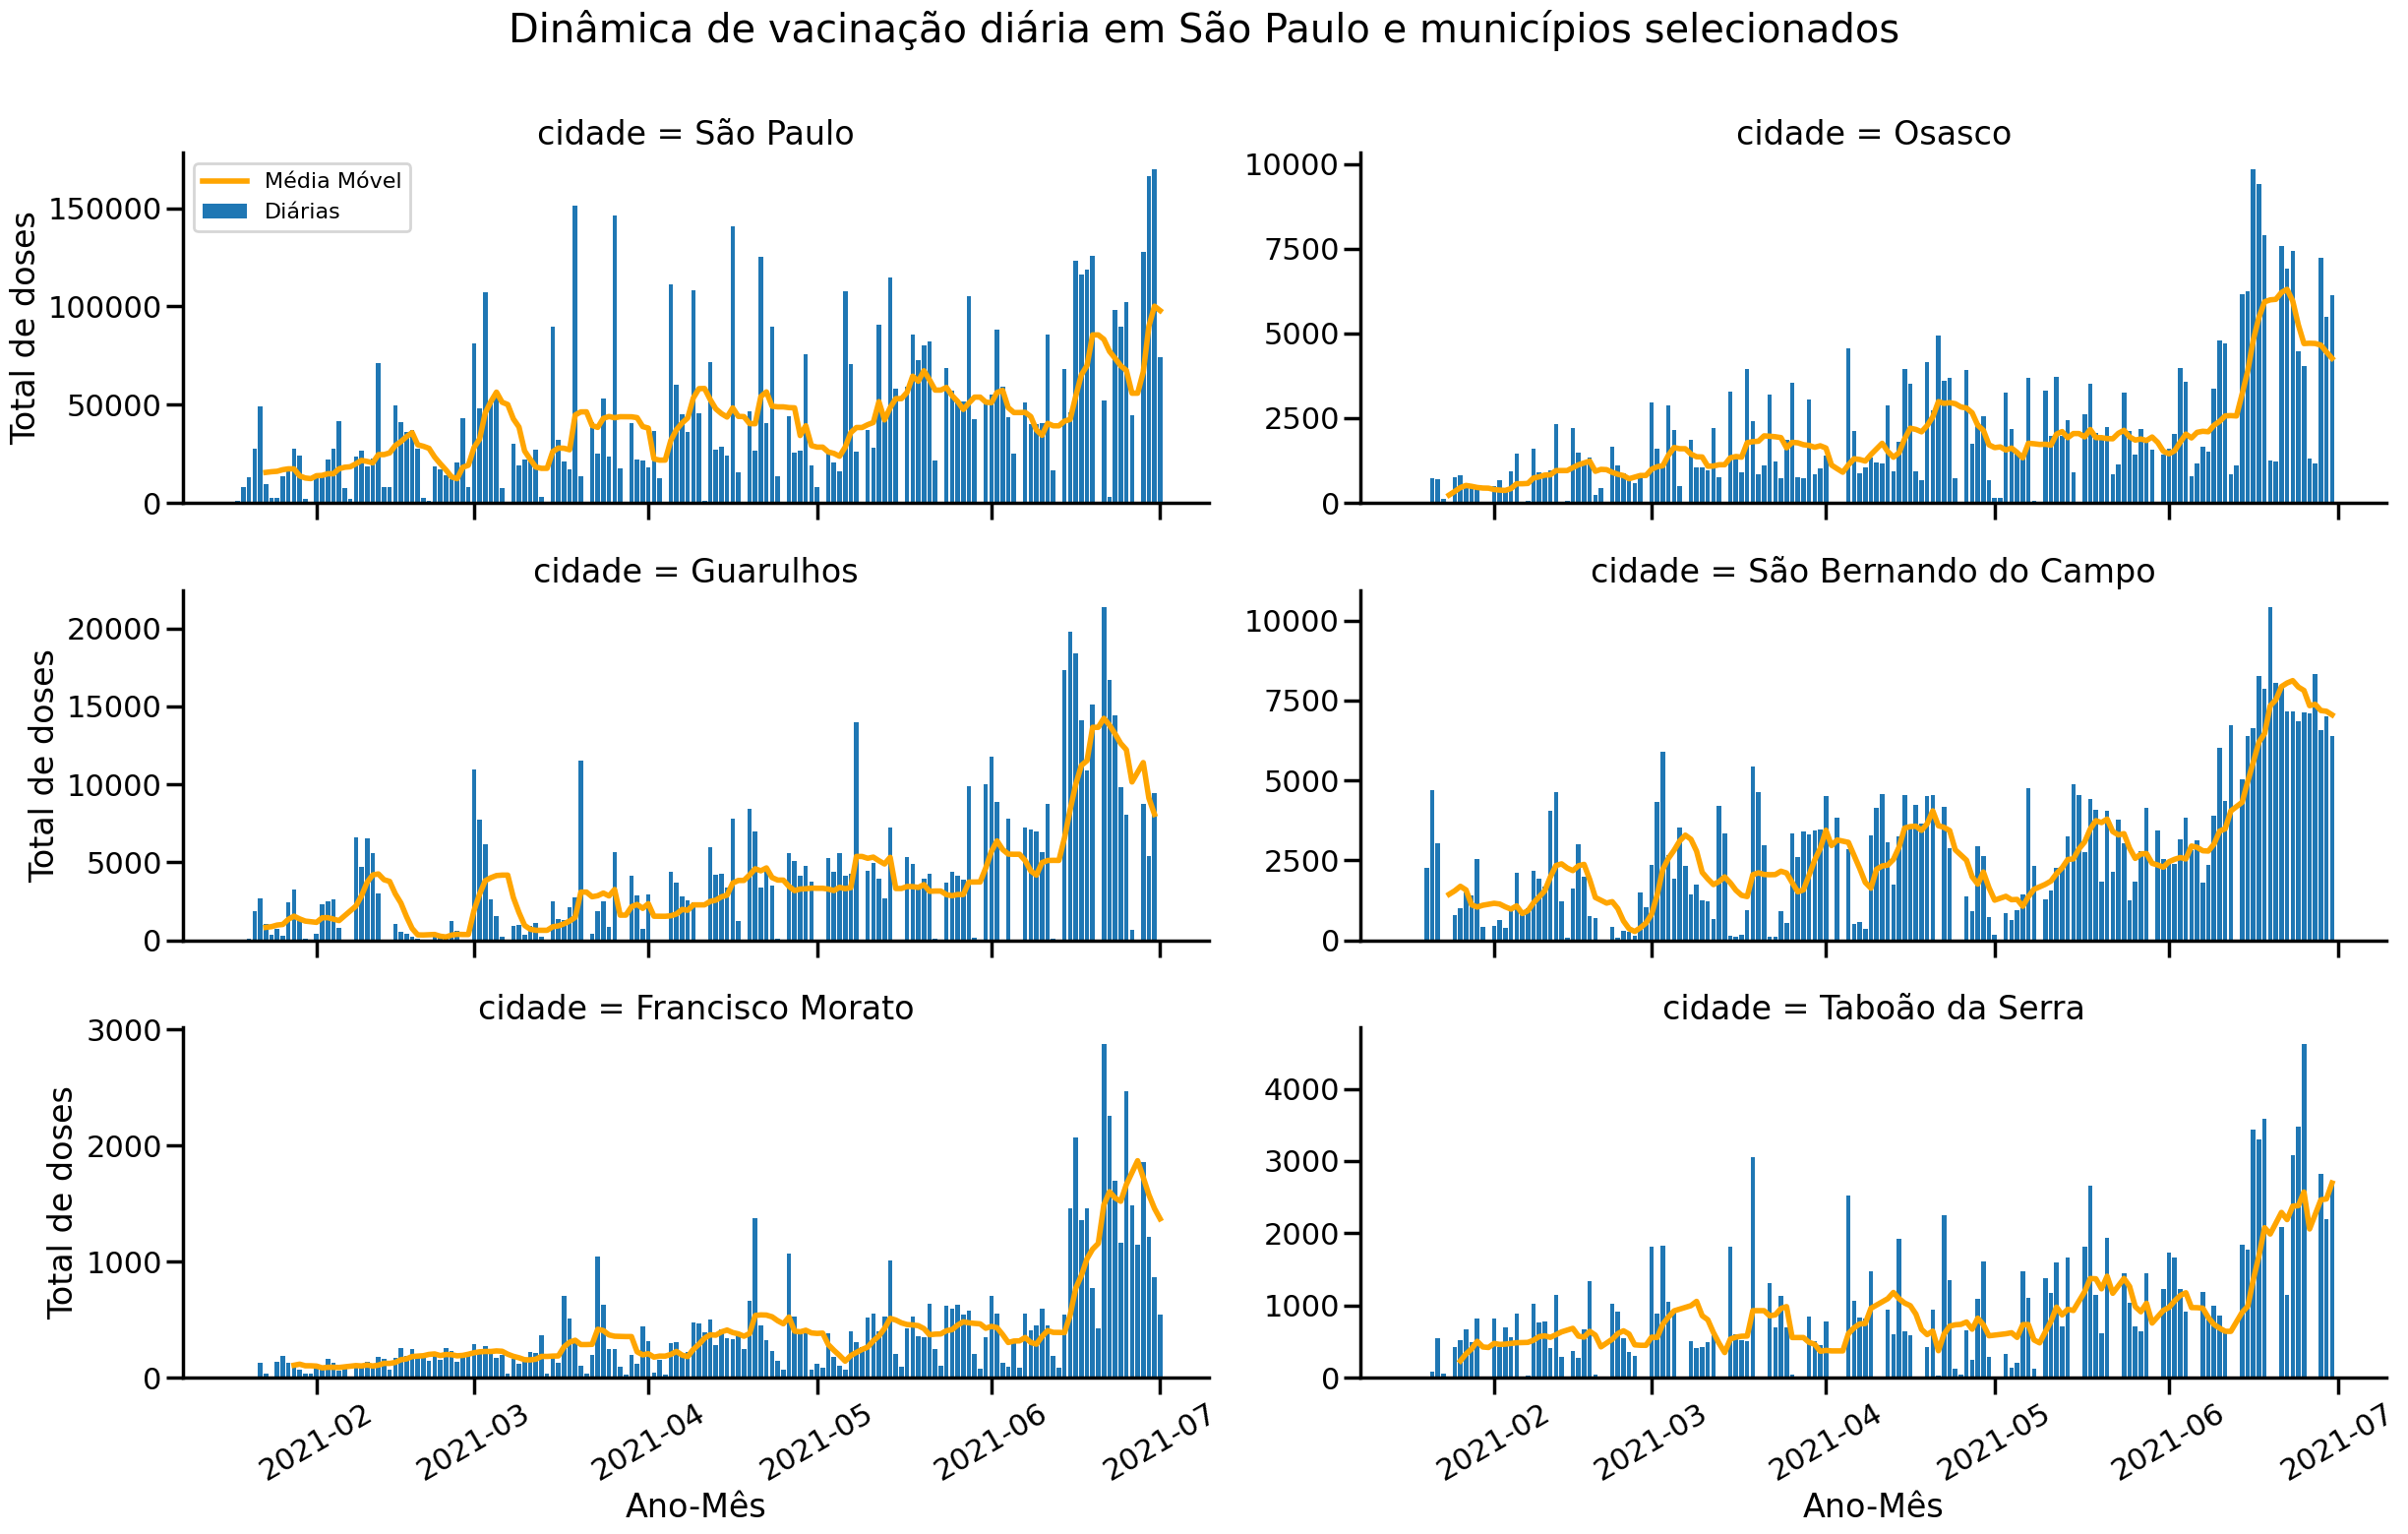

In [52]:
sns.set_context("poster")
g = sns.FacetGrid(data = vac_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.5)
g.map_dataframe(plt.bar, x = "Data", height = "Doses Aplicadas", label = "Diárias")
g.map_dataframe(sns.lineplot, x = "Data", y = "ma", linewidth = 4, color = "orange", label = "Média Móvel")
g.set_xticklabels(rotation = 30)
g.set_axis_labels("Ano-Mês", "Total de doses")
g.axes[0].legend(fontsize = 16, loc = "upper left")
g.fig.suptitle("Dinâmica de vacinação diária em São Paulo e municípios selecionados", y = 1.05)
plt.tight_layout()
plt.show()

Sem muitas novidades, vemos que o padrão de vacinação dos municípios além de São Paulo reflete bastante o padrão observado do geral para o estado. Em uma das [reportagens](https://g1.globo.com/sp/sao-paulo/noticia/2021/06/11/governo-de-sp-vai-distribuir-vacinas-contra-covid-19-da-pfizer-e-da-janssen-para-todos-os-municipios.ghtml) apresentadas aqui anteriormente, vimos que a vacina da Pfizer nos primeiros dias era aplicada somente na capital. Isso explica o fato da capital não ter apresentado o mesmo aumento significativo nas taxas de vacinação em Junho como apresentando por outras cidades. 

Dado que esse padrão foi observado para o estado como um todo, podemos começar a nos perguntar se é somente a proximidade com a capital que influenciou a dinâmica da RMSP, como propus anteriormente. De qualquer forma, esse resultado é bastante animador.

---

Cabe ressaltar aqui que análises de correlação cruzada nesse caso não seriam tão interessantes, devido ao volume de dados muito menor (~ 160 dias), e a relativa unanimidade dos ritmos de vacinação em todas as cidades não parece trazer muitas novidades.


Porém, podemos focar agora em outro aspecto, mais importante: o total cumulativo de doses aplicadas. Afinal, não estamos tão interessados no número de doses diárias, mas mais em quantas doses já foram (e serão aplicadas).

## Cumulativo

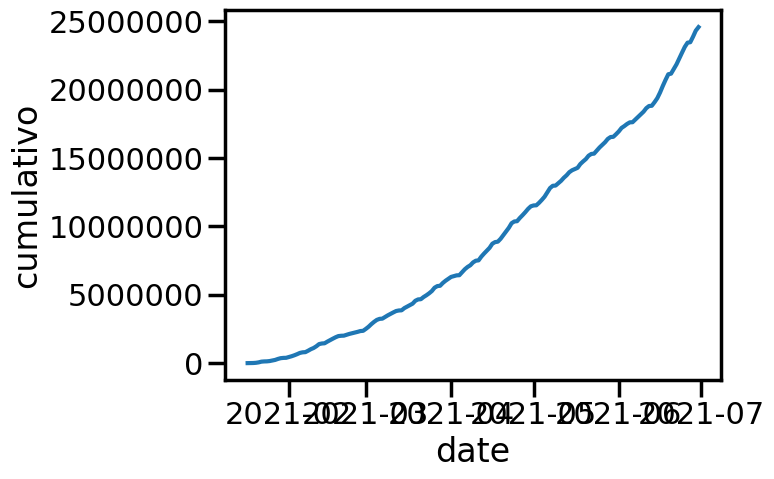

In [37]:
sns.lineplot(data = duas_doses, x = "date", y = "cumulativo")
plt.ticklabel_format(style='plain', axis='y')

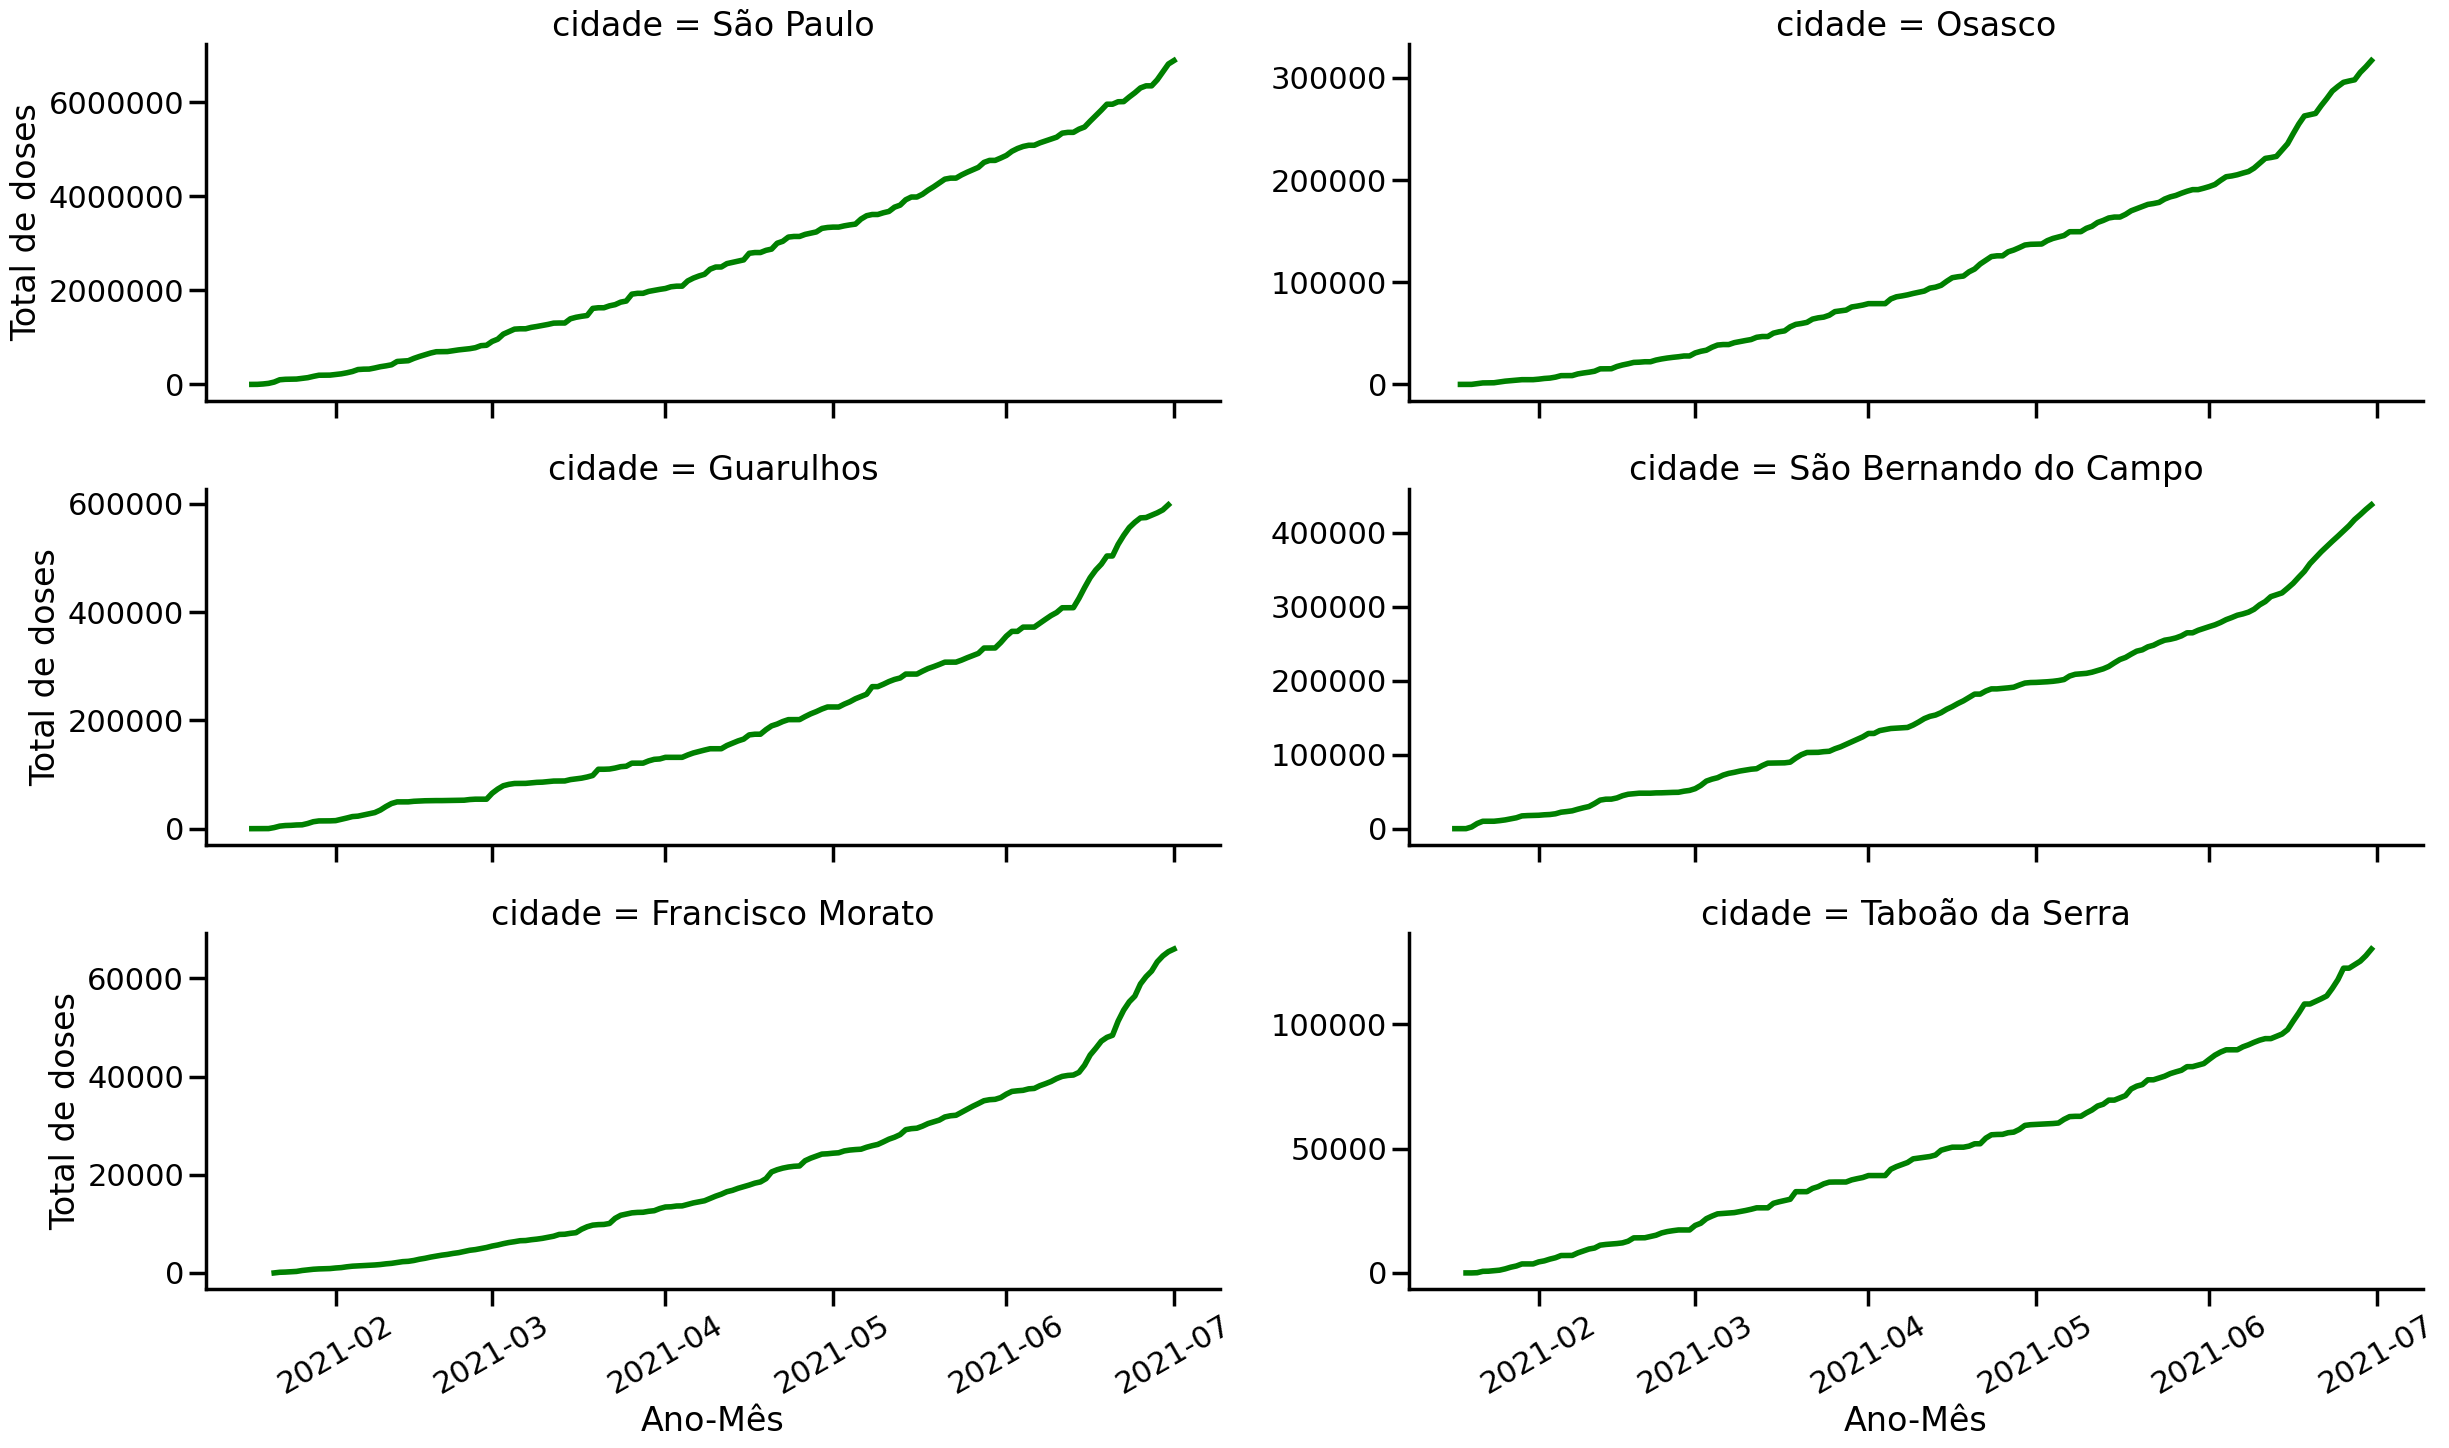

In [38]:
sns.set_context("poster")
g = sns.FacetGrid(data = vac_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.5)
g.map_dataframe(sns.lineplot, x = "Data", y = "cumulativo", linewidth = 4, color = "green")
g.set_xticklabels(rotation = 30)
g.set_axis_labels("Ano-Mês", "Total de doses")
g.axes.flat[0].ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

não tem muito segredo nem porque estimar correlação, sabemos que só vai subir, e até vemos a inflexão ali. vamos modelar como um modelo logistico, afinal, um dia todo mundo vai ser vacinado e não pode cair abaixo de 0.

o truque é pegar a população, considerar o dobro para saber o total necessario, e estimar 70% desse valor como o minimo. lembrar também que ainda não estamos vacinando menores de 18 anos, mas essa aproximação é relativamente realista

## Cumulativo

In [39]:
pop_sp = casos_full.query("city == 'São Paulo'").loc[:,"estimated_population"].unique()
pop_osa = casos_full.query("city == 'Osasco'").loc[:,"estimated_population"].unique()
pop_gru = casos_full.query("city == 'Guarulhos'").loc[:,"estimated_population"].unique()
pop_sbc = casos_full.query("city == 'São Bernardo do Campo'").loc[:,"estimated_population"].unique()
pop_fm = casos_full.query("city == 'Francisco Morato'").loc[:,"estimated_population"].unique()
pop_tab = casos_full.query("city == 'Taboão da Serra'").loc[:,"estimated_population"].unique()

In [40]:
dsy_sp = pd.DataFrame()
dsy_sp.loc[:,"ds"] = vac_sp.loc[:,"Data"]
dsy_sp.loc[:,"y"] = vac_sp.loc[:,"cumulativo"]
dsy_sp.loc[:,"cap"] = 2*pop_sp.repeat(len(dsy_sp))

dsy_osa = pd.DataFrame()
dsy_osa.loc[:,"ds"] = vac_osa.loc[:,"Data"]
dsy_osa.loc[:,"y"] = vac_osa.loc[:,"cumulativo"]
dsy_osa.loc[:,"cap"] = 2*pop_osa.repeat(len(dsy_osa))

dsy_gru = pd.DataFrame()
dsy_gru.loc[:,"ds"] = vac_gru.loc[:,"Data"]
dsy_gru.loc[:,"y"] = vac_gru.loc[:,"cumulativo"]
dsy_gru.loc[:,"cap"] = 2*pop_gru.repeat(len(dsy_gru))

dsy_sbc = pd.DataFrame()
dsy_sbc.loc[:,"ds"] = vac_sbc.loc[:,"Data"]
dsy_sbc.loc[:,"y"] = vac_sbc.loc[:,"cumulativo"]
dsy_sbc.loc[:,"cap"] = 2*pop_sbc.repeat(len(dsy_sbc))

dsy_fm = pd.DataFrame()
dsy_fm.loc[:,"ds"] = vac_fm.loc[:,"Data"]
dsy_fm.loc[:,"y"] = vac_fm.loc[:,"cumulativo"]
dsy_fm.loc[:,"cap"] = 2*pop_fm.repeat(len(dsy_fm))

dsy_tab = pd.DataFrame()
dsy_tab.loc[:,"ds"] = vac_tab.loc[:,"Data"]
dsy_tab.loc[:,"y"] = vac_tab.loc[:,"cumulativo"]
dsy_tab.loc[:,"cap"] = 2*pop_tab.repeat(len(dsy_tab))

In [41]:
m2_sp = run_model(df = dsy_sp, periods = 150, growth = "logistic", cap = 2*pop_sp)
m2_osa = run_model(df = dsy_osa, periods = 150, growth = "logistic", cap = 2*pop_osa)
m2_gru = run_model(df = dsy_gru, periods = 150, growth = "logistic", cap = 2*pop_gru)
m2_sbc = run_model(df = dsy_sbc, periods = 150, growth = "logistic", cap = 2*pop_sbc)
m2_fm = run_model(df = dsy_fm, periods = 150, growth = "logistic", cap = 2*pop_fm)
m2_tab = run_model(df = dsy_tab, periods = 150, growth = "logistic", cap = 2*pop_tab)

In [42]:
m2_tot = [m2_sp, m2_osa, m2_gru, m2_sbc, m2_fm, m2_tab]
pop = [pop_sp, pop_osa, pop_gru, pop_sbc, pop_fm, pop_tab]

<Figure size 2000x1000 with 0 Axes>

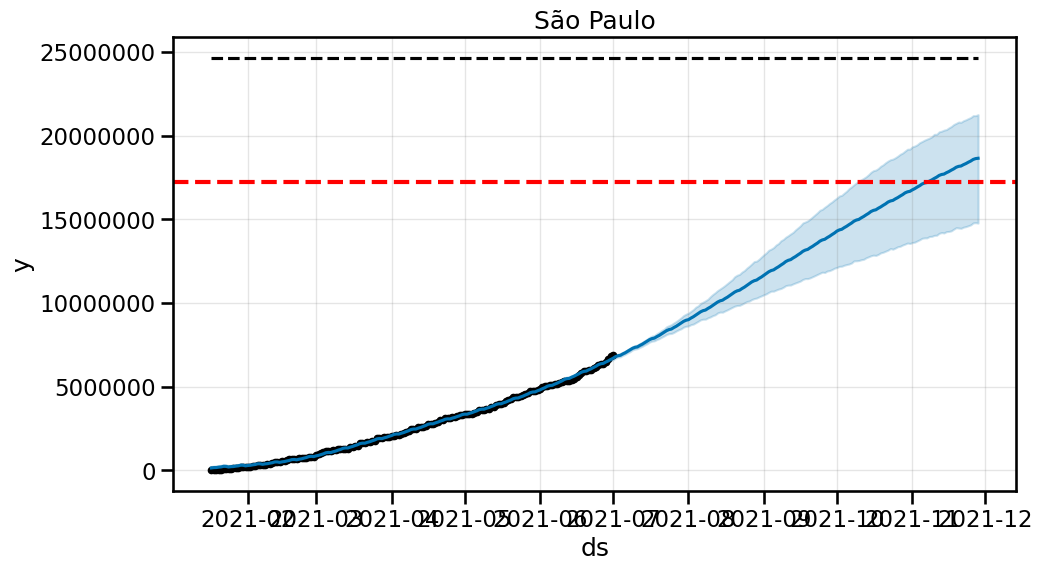

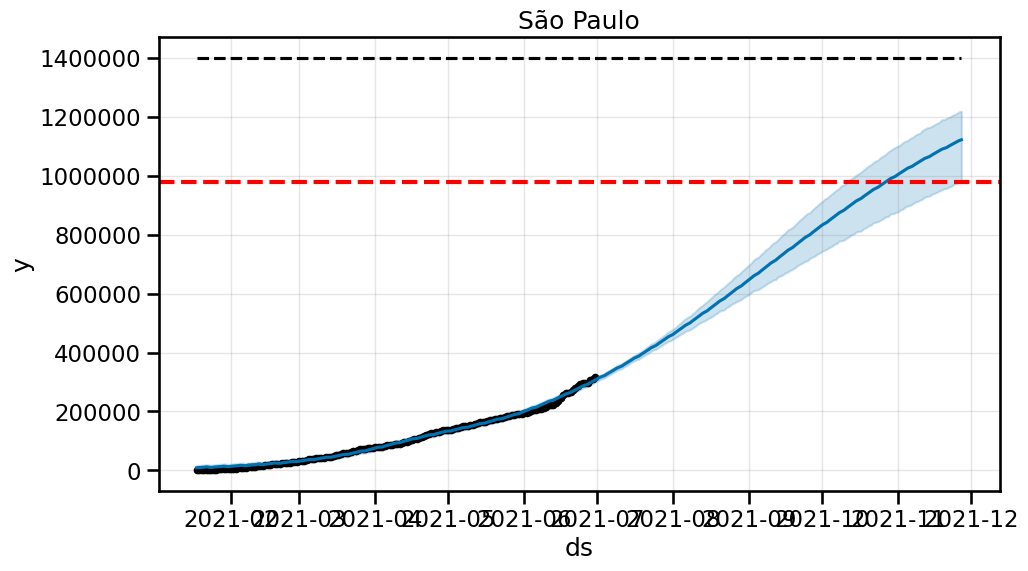

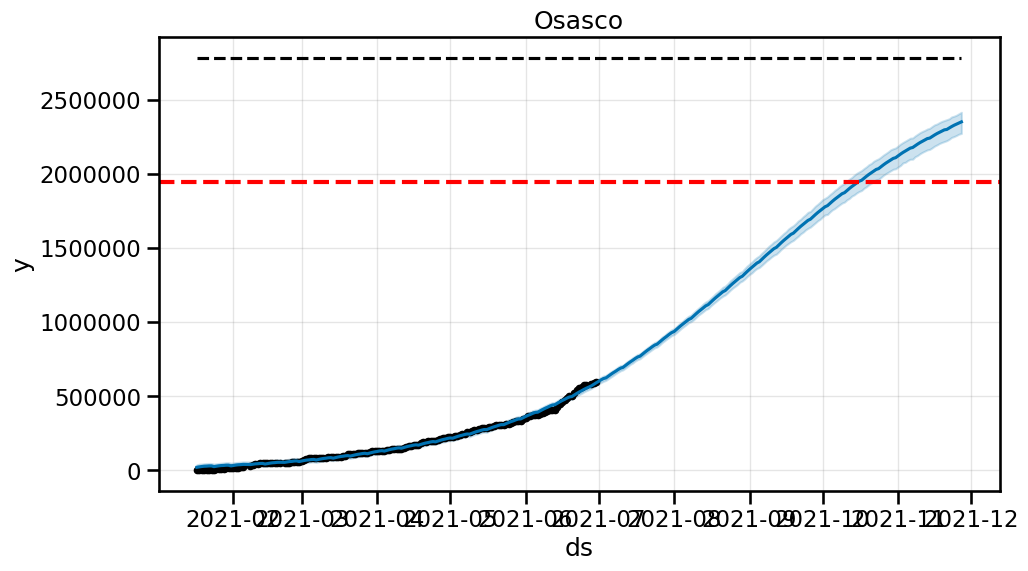

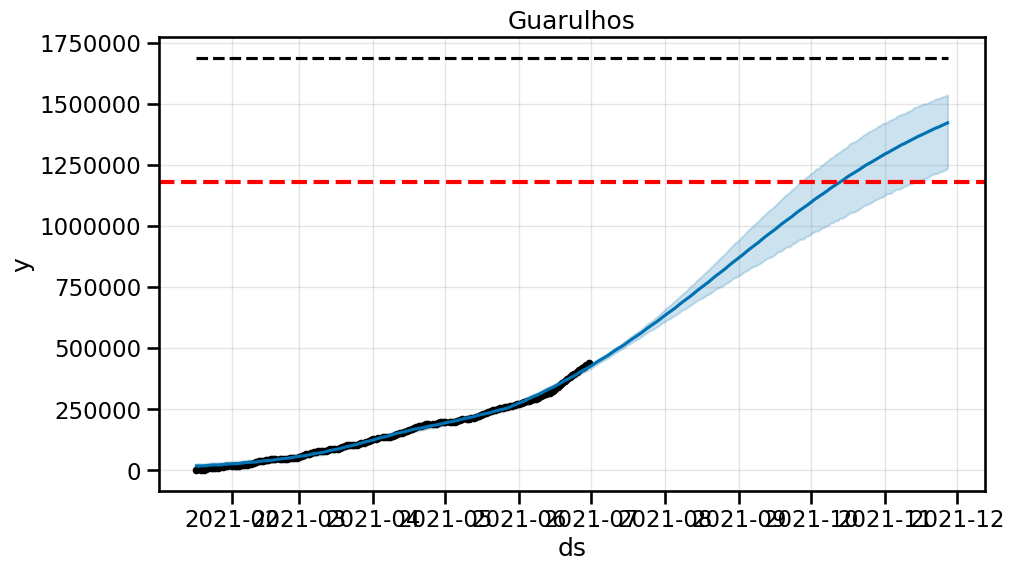

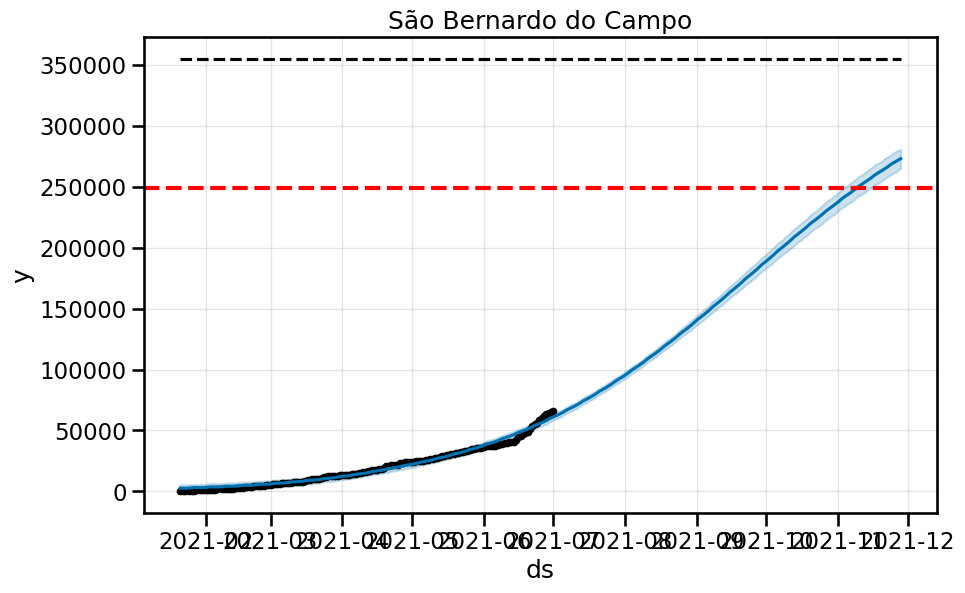

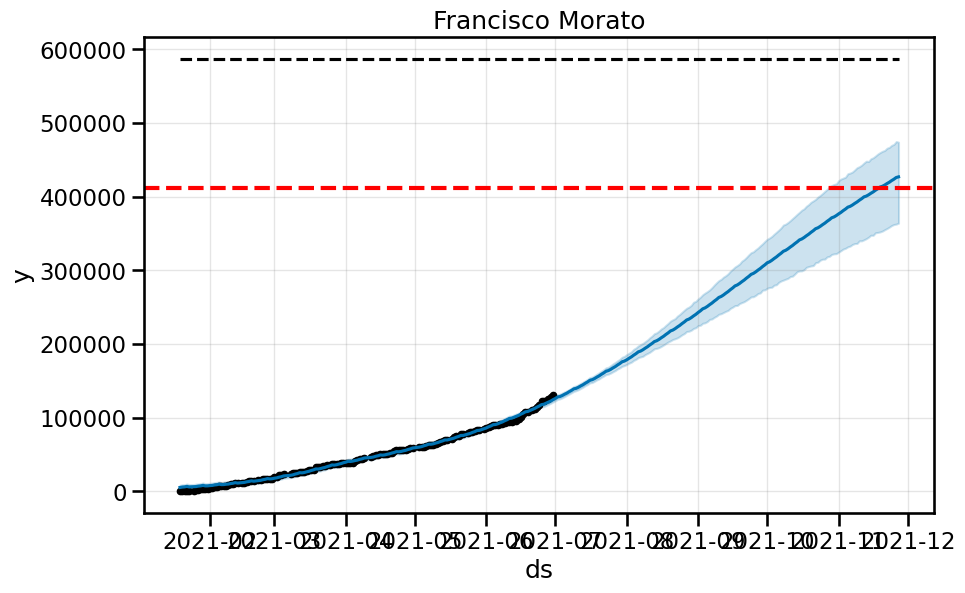

In [43]:
sns.set_context("talk")

fig = plt.figure(figsize = (20,10))

for k in range(0, 6):
  m2_tot[k][0].plot(m2_tot[k][1]);
  plt.title(cidades_modelos[k])
  plt.ticklabel_format(style = "plain", axis = "y")
  plt.axhline(y = (2*pop[k])*0.7, color = "red", lw = 3, ls = "--")

plt.show()

não vai demorar muito hein galera! até porque, sabemos que a taxa diaria vai aumentar, então podemos levar isso em conta

analise de cv com modelo logistico não é muito efetivo, valores muito pequenos:

In [44]:
df_cv = cross_validation(m2_sp[0], initial = "80 days", period = "14 days", horizon = "14 days")

In [45]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-04-09,2.455015e+06,2.396876e+06,2.517195e+06,2449872,2021-04-08
1,2021-04-10,2.489828e+06,2.429234e+06,2.547042e+06,2495721,2021-04-08
2,2021-04-11,2.506989e+06,2.448343e+06,2.569865e+06,2496752,2021-04-08
3,2021-04-12,2.574573e+06,2.514101e+06,2.636517e+06,2568370,2021-04-08
4,2021-04-13,2.627759e+06,2.568029e+06,2.690287e+06,2595210,2021-04-08
...,...,...,...,...,...,...
79,2021-06-27,6.301886e+06,6.201487e+06,6.404072e+06,6348821,2021-06-17
80,2021-06-28,6.376243e+06,6.271567e+06,6.480011e+06,6476583,2021-06-17
81,2021-06-29,6.437590e+06,6.326856e+06,6.542425e+06,6643102,2021-06-17
82,2021-06-30,6.513290e+06,6.392120e+06,6.629617e+06,6812811,2021-06-17


Valores pequenos, nem vale a pena olhar, olhar só pro erro: erro aumenta conforme o tempo passa, ter cuidado

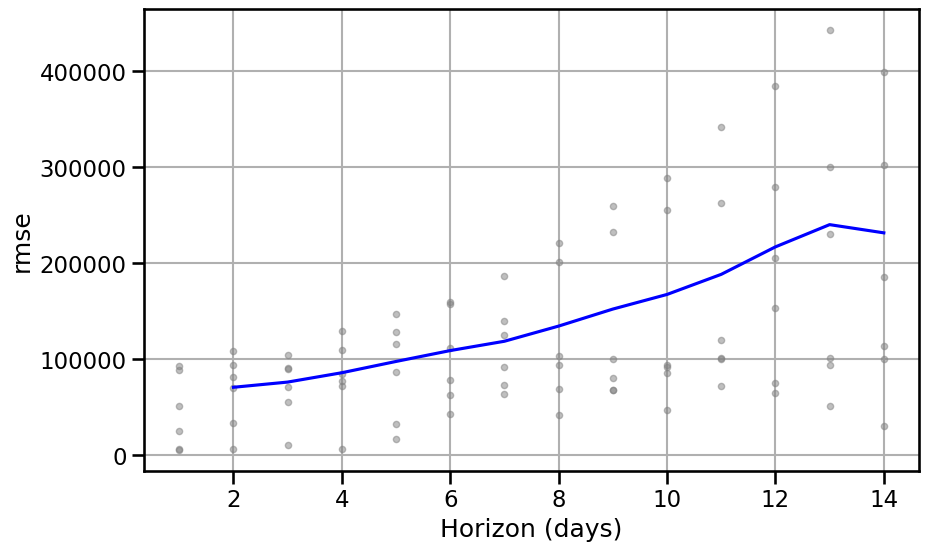

In [46]:
plot_cross_validation_metric(df_cv, metric = "rmse");

# Previsões

Vamos novamente olhar primeiro para o estado, a fim de balizar nossas expectativas: a taxa diária também não pode crescer indefinidamente. Dificilmente ela atingirá uma capacidade previsível, pois conforme o tempo passa, mais pessoas já estariam vacinadas e o ritmo também pode acabar diminuindo mais próximo do final da vacinação.

Uma forma simples de realizar essa estimativa é considerar quais a previsões máximas de vacinação para o Brasil. A Anvisa considera que o SUS é capaz de vacinar cerca de [3 milhões de pessoas por dia](https://www.bbc.com/portuguese/brasil-56104951), no Brasil inteiro. Podemos então, pegar essa taxa e imaginar que, se a população do Estado de São Paulo corresponde a [20% da população do Brasil](https://pt.wikipedia.org/wiki/S%C3%A3o_Paulo_%28estado%29), vamos imaginar que a capacidade máxima de vacinação em São Paulo seja de 20/100 * 3000000 = 600000 pessoas por dia. Vamos tentar modelar como a taxa de vacinação diária pode crescer para se alcançar esses valores, ou valores próximos.

In [22]:
sns.reset_defaults()

Para a modelagem de previsões, utilizei a biblioteca [Facebook Prophet](https://facebook.github.io/prophet/). Primeiro, defini a função que vai aplicar a modelagem, já que ela será repetida diversas vezes durante o projeto.

In [26]:
def run_model(df, 
              periods,
              changepoints = None,
              n_changepoints = 25, 
              changepoint_prior_scale = 0.05, 
              changepoint_range = 0.8,
              holidays = None,
              growth = "linear",
              cap = None):
  
  mx = Prophet(changepoints = changepoints, 
               n_changepoints = n_changepoints,
               changepoint_prior_scale = changepoint_prior_scale,
               changepoint_range = changepoint_range,
               holidays = holidays,
               growth = growth) # chama o objeto de modelo

  mx.fit(df) # associa o modelo ao dataframe de treino

  if growth == "logistic" :
    df_prev = mx.make_future_dataframe(periods = periods)
    df_prev.loc[:,"cap"] = cap.repeat(len(df_prev)) # cria o dataframe de previsão que vai ser gerado mas não utilizado fora
    prev = mx.predict(df_prev) # faz a previsao baseada no modelo ajustado e no dataframe de previsao

  else : 
    df_prev = mx.make_future_dataframe(periods = periods) # cria o dataframe de previsão que vai ser gerado mas não utilizado fora
    prev = mx.predict(df_prev) # faz a previsao baseada no modelo ajustado e no dataframe de previsao

  return mx, prev # retorna o modelo como elemento [0], e a previsao como elemento [1]

### Para a função rodar na forma mais básica, precisamos apenas passar o dataframe de treino, já formatado como o prophet
### usa, e o periods que vamos estimar os dados.

### Como há uma série de parâmetros da função Prophet, você pode adicioná-los na definição da função.
### Para a aula, vamos brincar com os parâmetros de changepoints, os quais eu deixei com o default da função.

## Taxas diarias

Vamos modelar então a forma como a taxa pode crescer no Estado de São Paulo, tendo como objetivo descobrir quando podemos alcançar uma taxa em torno de 600000 pessoas. 

Para o ajuste do modelo, algumas considerações são necessárias. Primeiro, como vimos anteriormente, a taxa de vacinação diária aumentou bastante nos últimos dias de Junho. Em uma abordagem mais tradicional de modelos de previsão, poderíamos separar uma quantidade de dados de treino e de teste geralmente na proporção 80/20, 70/30. Porém, remover qualquer proporção maior que 5% desses dados **não captura** esse aumento final, devido ao grande aporte de novas vacinas, sobretudo Pfizer e Janssen, que são de suma importância para a aceleração do ritmo de vacinação em São Paulo. Portanto, seria inviável remover dados desse modelo de previsão. É importante ressaltar que isso pode levar à uma menor qualidade dessas previsões em relação a outros modelos de previsão, então tenhamos isso em mente durante essa análise.

Segundo, os parâmetros foram ajustados após diversas rodadas de teste, que não cabe repetir na apresentação do projeto final. Busquei atingir o melhor ajuste dos pontos de inflexão da curva no começo e no final, com o menor erro possível para o tempo de previsão de 90 dias. Afinal, de qualquer forma não esperamos aumentos muito expressivos nessa taxa. Seguimos então para os modelos:

#### Validação


Uma métrica de validação que podemos aplicar para esse modelo é a [validação cruzada](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation), que consegue medir a taxa de erro do modelo em diferentes janelas de observação, comparando-se o resultado previsto com o dado real. Dessa forma, podemos estimar como o modelo erra ou não o ajuste, e considerar como isso pode influenciar os resultados de previsão. Utilizando uma janela de 7 dias, já que o aumento de vacinação ocorreu muito recentemente nos nossos dados, e iniciando-se mais ou menos no meio do nosso intervalo, vamos olhar para esse resultado: 

In [58]:
df_cv = cross_validation(m2[0], initial = "80 days", period = "7 days", horizon = "7 days")

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-04-08,161575.478438,120760.302957,206872.020802,125005,2021-04-07
1,2021-04-09,171990.619390,128775.932098,214271.601135,209674,2021-04-07
2,2021-04-10,111997.696962,67165.180737,156121.969381,123529,2021-04-07
3,2021-04-11,75685.886602,32202.916923,117968.840294,25880,2021-04-07
4,2021-04-12,178202.305457,133315.056602,222850.283042,272738,2021-04-07
...,...,...,...,...,...,...
79,2021-06-26,326929.873739,263807.756492,390363.528295,307998,2021-06-23
80,2021-06-27,254497.615634,190331.286137,318178.352545,35674,2021-06-23
81,2021-06-28,405496.757420,342707.800868,465046.515058,402763,2021-06-23
82,2021-06-29,417947.194600,351191.418955,484569.390807,444026,2021-06-23


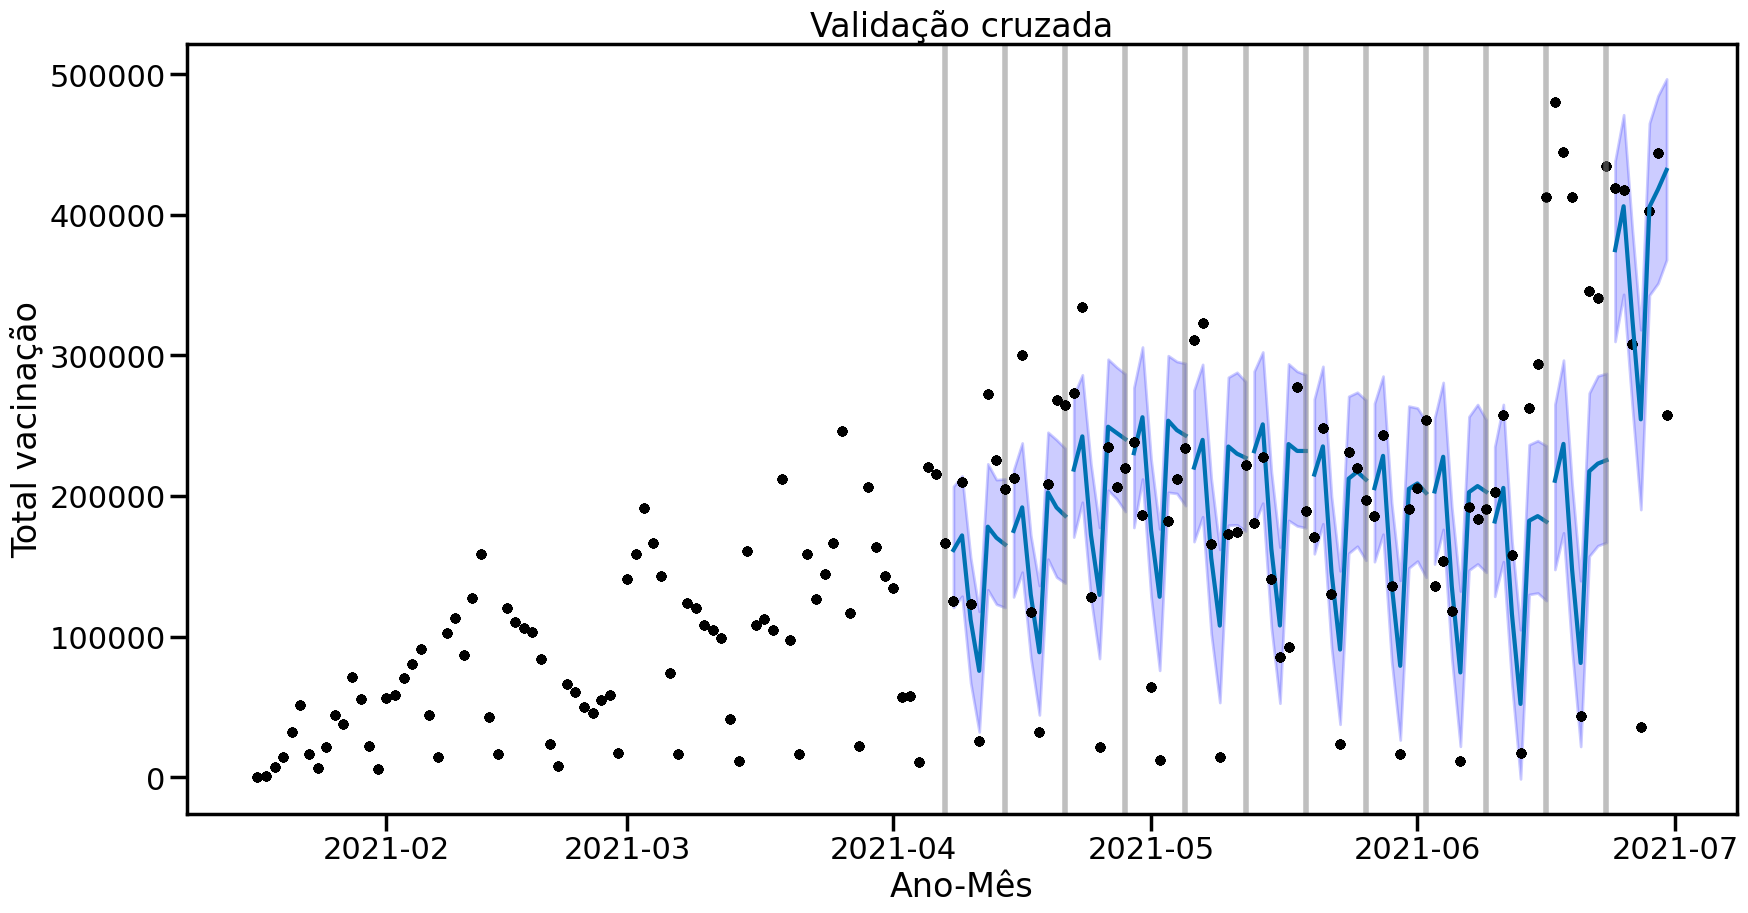

In [61]:
sns.set_context("poster")
lista_cutoff = df_cv['cutoff'].unique()

plt.figure(figsize = (20,10))
for cutoff in lista_cutoff:

    df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
    ax = plt.plot(m2[0].history['ds'].values, m2[0].history['y'], 'k.')

    plt.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2', label='previsão')

    plt.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                    df_cv_cut['yhat_upper'], color='blue',
                    alpha=0.2, label='intervalo de confiança')
    
    plt.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5, label='cutoff')
    
plt.title(f'Validação cruzada')
plt.ylabel('Vacinas aplicadas')
plt.xlabel('Ano-Mês')
fig.tight_layout()
plt.show()

O que podemos inferir desse gráfico é que, primeiro, o modelo captou bem as variações semanais do ritmo de vacinação, menores nos finais de semana; e também identificou corretamente o aumento expressivo da taxa de vacinação nos últimos 7 dias. 

Uma outr métrica que podemos observar é uma métrica simples de avaliação do modelo, o [erro quadrático médio](https://aditi-mittal.medium.com/cross-validation-and-performance-measures-in-machine-learning-9dabdbed5459) das janelas de previsão:

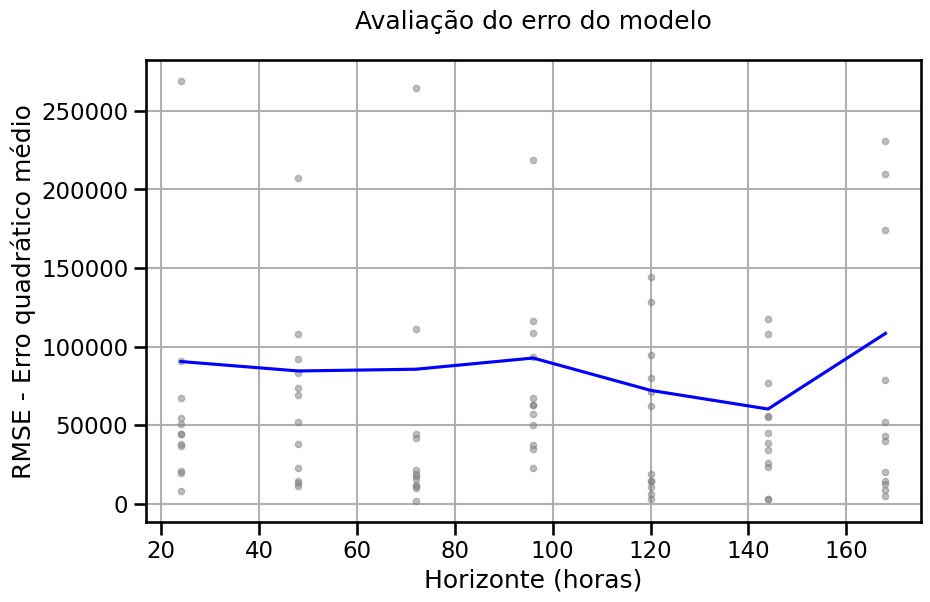

In [66]:
sns.set_context("talk")
plot_cross_validation_metric(df_cv, metric = "rmse");
plt.title("Avaliação do erro do modelo", y = 1.05)
plt.xlabel("Horizonte (horas)")
plt.ylabel("RMSE - Erro quadrático médio")
plt.show()

Podemos observar então, que o modelo comporta-se relativamente bem nos intervalos de 7 dias, com maior taxa de erro ao final.

# Cidades

Vamos agora realizar as previsões de aumento da taxa entre os municípios selecionados, mantendo-se os mesmos parâmetros da taxa do estado. A única mudança está na cidade de São Paulo, que não possui o padrão de aumento expressivo dos últimos dias.